In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# !pip install wandb

In [3]:
import wandb
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: andrewhealey (roboflow2). Use `wandb login --relogin` to force relogin


True

In [140]:
import supervision as sv

#
# download dataset with a few labelled images (5-10 is recommended, but you can go as high as you like)
#
from roboflow import login,Roboflow

login()
rf = Roboflow()

%cd datasets/
project = rf.workspace("roboflow-4rfmv").project("climbing-y56wy")
dataset = project.version(5).download("coco-segmentation")

climbing_dataset = sv.DetectionDataset.from_coco(
    images_directory_path=f"{dataset.location}/train",
    annotations_path=f"{dataset.location}/train/_annotations.coco.json",
    force_masks=True
)

valid_dataset = sv.DetectionDataset.from_coco(
    images_directory_path=f"{dataset.location}/valid",
    annotations_path=f"{dataset.location}/valid/_annotations.coco.json",
    force_masks=True
)

%cd ..

You are already logged into Roboflow. To make a different login, run roboflow.login(force=True).


/home/andrewhealey/sam-fine-tuning/datasets
loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to Climbing-5 in coco-segmentation:: 100%|██████████| 51/51 [00:00<00:00, 2080.39it/s]


/home/andrewhealey/sam-fine-tuning


In [5]:
from persam.load import load_predictor

predictor = load_predictor("vit_t")

from fine_tune.samed import LoRA_Mask_Decoder

# lora_mask_decoder = LoRA_Mask_Decoder(predictor.model.mask_decoder,r=16)
# mask_decoder = lora_mask_decoder.mask_decoder.cuda()
mask_decoder = predictor.model.mask_decoder

# import torch
# state_dict = torch.load("mask_decoder.pt")
# mask_decoder.load_state_dict(state_dict)

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [6]:
from fine_tune.common import SamBoxDataset, SamPointDataset, SamNextMaskDataset, RandomPointDataset, get_max_iou_masks

import torch
device = torch.device('cuda:0')

from torch.utils.data import ConcatDataset

rand_point_dataset = RandomPointDataset(climbing_dataset, predictor, device, points_per_img = 40)
point_dataset = SamPointDataset(climbing_dataset, predictor, device, points_per_mask = 1)
box_dataset = SamBoxDataset(climbing_dataset, predictor,device)

combo_dataset = ConcatDataset([rand_point_dataset, point_dataset])

print("next mask dataset")
next_rand_point_dataset = SamNextMaskDataset(climbing_dataset,predictor,device,secondary_prompter=rand_point_dataset)
print("next point dataset")
next_point_dataset = SamNextMaskDataset(climbing_dataset,predictor,device,secondary_prompter=point_dataset)

next_combo_dataset = ConcatDataset([next_rand_point_dataset, next_point_dataset])

  0%|          | 0/31 [00:00<?, ?it/s]

100%|██████████| 31/31 [00:00<00:00, 6908.42it/s]


next mask dataset


100%|██████████| 31/31 [02:05<00:00,  4.04s/it]


next point dataset


100%|██████████| 31/31 [00:12<00:00,  2.38it/s]


In [142]:
valid_point_dataset = SamPointDataset(valid_dataset, predictor, device, points_per_mask=1)
valid_next_point_dataset = SamNextMaskDataset(valid_dataset, predictor, device, secondary_prompter=valid_point_dataset)

valid_rand_point_dataset = RandomPointDataset(valid_dataset, predictor, device, points_per_img=100)
valid_next_rand_point_dataset = SamNextMaskDataset(valid_dataset, predictor, device, secondary_prompter=valid_rand_point_dataset)

  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [01:06<00:00,  8.34s/it]


In [143]:
valid_curr_dataset = ConcatDataset([valid_next_rand_point_dataset,valid_next_point_dataset])

In [7]:
len(rand_point_dataset),len(point_dataset)

(1240, 2833)

In [51]:
from fine_tune.common import SamDataset

In [52]:
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR
from timm.optim import AdamW

# Define your model and other necessary components here

# Hyperparameters
initial_lr = 2e-4
warmup_steps = 25000
total_steps = 150_000
batch_size = 30 # perform gradient accumulation for this--they do 256 images per batch.
weight_decay = 0.1

lr_decay_steps = [2/3., 0.95]
lr_decay_steps = [int(total_steps * step) for step in lr_decay_steps]

lr_decay_factor = 0.1

optimizer = optim.AdamW(predictor.model.mask_decoder.parameters(), lr=initial_lr, betas=(0.9, 0.999), weight_decay=weight_decay) # criterion = torch.nn.CrossEntropyLoss()

# Learning rate warmup schedule
def warmup_lambda(current_step):
    if current_step < warmup_steps:
        return float(current_step) / float(max(1, warmup_steps))
    return 1.0

warmup_scheduler = LambdaLR(optimizer, lr_lambda=warmup_lambda)

# Step-wise learning rate decay schedule
def lr_decay_lambda(current_step):
    if current_step in lr_decay_steps:
        return lr_decay_factor
    return 1.0

lr_decay_scheduler = LambdaLR(optimizer, lr_lambda=lr_decay_lambda)

In [53]:
curr_dataset = next_combo_dataset
run_grad = True

In [54]:
import torch
from torch import nn
import cv2
from torch.nn.functional import threshold, normalize
from numpy.random import permutation
from tqdm import tqdm

from persam.persam_f import calculate_sigmoid_focal_loss, calculate_dice_loss

from torch.nn import functional as F
import json

log_period = 200 # a few batches
wandb_log_period = 20

# lr = 1e-5
# optimizer = torch.optim.Adam(predictor.model.mask_decoder.parameters(), lr=lr)

run = wandb.init(
    # Set the project where this run will be logged
    project="sam-fine-tune",
    # Track hyperparameters and run metadata
    config={
        "learning_rate": initial_lr,
        "iters": total_steps,
        "batch_size": batch_size,
        "lr_decay_steps": json.dumps(lr_decay_steps),
    })


loss_fn = nn.MSELoss()

curr_iters = 0
accumulated_loss = 0

# track running avg of loss
recent_losses = []
recent_mses = []

# iter through dataset in random order

while curr_iters < total_steps:
    for i,idx in enumerate(tqdm(permutation(len(curr_dataset)))):
        curr_iters += 1

        decoder_input, gt_masks, (input_size,original_size) = curr_dataset[idx]

        _,H,W = gt_masks.shape

        low_res_masks, iou_predictions = mask_decoder(**decoder_input)

        high_res_masks = F.interpolate(
                low_res_masks,
                (H, W),
                mode="bilinear",
                align_corners=False,
            )
        high_res_masks = high_res_masks.squeeze(0)
        assert len(high_res_masks.shape) == 3,f"Shape is {high_res_masks.shape}" # 1 or 3, H, W

        upscaled_masks = predictor.model.postprocess_masks(low_res_masks, input_size, original_size).to(device)
        binary_masks = normalize(threshold(upscaled_masks, 0.0, 0)).to(device)[0,:,:,:]

        gt_binary_mask, binary_mask, iou, pred_idx = get_max_iou_masks(gt_masks,binary_masks)
        pred_iou = iou_predictions[0,pred_idx]
        pred_mask = high_res_masks[pred_idx]

        assert gt_binary_mask.shape == binary_mask.shape,f"Mismatched shapes {gt_binary_mask.shape}, {binary_mask.shape}"
        h,w = gt_binary_mask.shape


        flat_pred_mask = pred_mask.view(1,-1)
        flat_gt_binary_mask = gt_binary_mask.view(1,-1)

        focal_loss = calculate_sigmoid_focal_loss(flat_pred_mask, flat_gt_binary_mask,should_sigmoid=True)
        dice_loss = calculate_dice_loss(flat_pred_mask, flat_gt_binary_mask,should_sigmoid=True)

        # mse loss between predicted and real IoU
        mse_loss = loss_fn(pred_iou, iou)

        loss = 20*focal_loss + dice_loss + mse_loss

        recent_losses += [loss.item()]
        recent_losses = recent_losses[-log_period:]

        if i % wandb_log_period == 0:
            wandb.log({
                "loss": loss.cpu().item(),
                "focal_loss": focal_loss.cpu().item(),
                "dice_loss": dice_loss.cpu().item(),
                "mse_loss": mse_loss.cpu().item(),
            })

        if i % log_period == 0:
            print(f"Loss: {sum(recent_losses)/len(recent_losses)}")

        if not run_grad: continue
        accumulated_loss += loss
        if curr_iters % batch_size == 0:
            optimizer.zero_grad()
            accumulated_loss /= batch_size
            accumulated_loss.backward()
            optimizer.step()
            accumulated_loss = 0
        
        warmup_scheduler.step(curr_iters)

        # Set learning rate for the step-wise decay phase
        lr_decay_scheduler.step(curr_iters)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


dice_loss,███▂█▁▆▁██
focal_loss,▁▁▂▁▁▁▅▁█▂
loss,▆▆▆▁▆▁▆▁█▆
mse_loss,▁▂▂▁▃▁█▁▂▁
dice_loss,0.99688
focal_loss,0.00261
loss,1.04956
mse_loss,0.00053


  0%|          | 0/12565 [00:00<?, ?it/s]Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  0%|          | 2/12565 [00:00<22:02,  9.50it/s]

Loss: 1.175514817237854


  2%|▏         | 202/12565 [00:17<16:17, 12.65it/s]

Loss: 0.7766763247549534


  3%|▎         | 402/12565 [00:36<17:02, 11.89it/s]

Loss: 0.7587226765789091


  5%|▍         | 602/12565 [00:54<23:13,  8.59it/s]

Loss: 0.7193863616511226


  6%|▋         | 802/12565 [01:11<15:19, 12.79it/s]

Loss: 0.6836732930317521


  8%|▊         | 1002/12565 [01:29<16:06, 11.97it/s]

Loss: 0.6335358144715428


 10%|▉         | 1202/12565 [01:48<22:50,  8.29it/s]

Loss: 0.6100238354690373


 11%|█         | 1402/12565 [02:05<14:17, 13.02it/s]

Loss: 0.6475313387438655


 13%|█▎        | 1602/12565 [02:23<14:53, 12.27it/s]

Loss: 0.628200030066073


 14%|█▍        | 1802/12565 [02:41<20:47,  8.63it/s]

Loss: 0.5548916990682483


 16%|█▌        | 2002/12565 [02:59<13:37, 12.91it/s]

Loss: 0.5917705615237355


 18%|█▊        | 2202/12565 [03:16<14:15, 12.11it/s]

Loss: 0.5384110300056636


 19%|█▉        | 2402/12565 [03:34<19:23,  8.73it/s]

Loss: 0.5792554190196096


 21%|██        | 2602/12565 [03:52<12:35, 13.19it/s]

Loss: 0.5915444071590901


 22%|██▏       | 2802/12565 [04:09<13:22, 12.17it/s]

Loss: 0.5564765373803675


 24%|██▍       | 3002/12565 [04:27<18:20,  8.69it/s]

Loss: 0.5574496192485094


 25%|██▌       | 3202/12565 [04:45<12:05, 12.90it/s]

Loss: 0.5797899474203586


 27%|██▋       | 3402/12565 [05:03<12:25, 12.28it/s]

Loss: 0.5154193061217666


 29%|██▊       | 3602/12565 [05:21<18:14,  8.19it/s]

Loss: 0.6596611254662276


 30%|███       | 3802/12565 [05:39<12:09, 12.02it/s]

Loss: 0.5527214989624918


 32%|███▏      | 4002/12565 [05:58<12:26, 11.47it/s]

Loss: 0.6476365738455206


 33%|███▎      | 4202/12565 [06:16<16:01,  8.70it/s]

Loss: 0.5846400916203857


 35%|███▌      | 4402/12565 [06:33<10:20, 13.15it/s]

Loss: 0.5939675924368203


 37%|███▋      | 4602/12565 [06:51<11:07, 11.93it/s]

Loss: 0.6138748647086323


 38%|███▊      | 4802/12565 [07:09<15:17,  8.46it/s]

Loss: 0.6032319619879126


 40%|███▉      | 5002/12565 [07:26<09:33, 13.18it/s]

Loss: 0.6439138874039054


 41%|████▏     | 5202/12565 [07:44<10:13, 12.01it/s]

Loss: 0.5391228288412094


 43%|████▎     | 5402/12565 [08:02<13:48,  8.65it/s]

Loss: 0.5442142086848617


 45%|████▍     | 5602/12565 [08:20<08:49, 13.14it/s]

Loss: 0.6411528581753373


 46%|████▌     | 5802/12565 [08:38<09:39, 11.68it/s]

Loss: 0.6614993408322334


 48%|████▊     | 6002/12565 [08:56<13:23,  8.16it/s]

Loss: 0.5563832240924239


 49%|████▉     | 6202/12565 [09:13<08:08, 13.03it/s]

Loss: 0.5490587216615677


 51%|█████     | 6402/12565 [09:31<08:31, 12.06it/s]

Loss: 0.6382078286260366


 53%|█████▎    | 6602/12565 [09:49<11:24,  8.71it/s]

Loss: 0.6044803883321583


 54%|█████▍    | 6802/12565 [10:06<07:18, 13.15it/s]

Loss: 0.5329191330261529


 56%|█████▌    | 7002/12565 [10:24<07:40, 12.09it/s]

Loss: 0.6632677083648741


 57%|█████▋    | 7202/12565 [10:43<10:57,  8.15it/s]

Loss: 0.5748486897349357


 59%|█████▉    | 7402/12565 [11:01<06:47, 12.68it/s]

Loss: 0.5885311419516802


 61%|██████    | 7602/12565 [11:19<06:46, 12.21it/s]

Loss: 0.5271183234266936


 62%|██████▏   | 7802/12565 [11:37<09:31,  8.33it/s]

Loss: 0.6469691308215261


 64%|██████▎   | 8002/12565 [11:54<05:51, 13.00it/s]

Loss: 0.6217266282811761


 65%|██████▌   | 8202/12565 [12:12<06:02, 12.04it/s]

Loss: 0.5620403600111604


 67%|██████▋   | 8402/12565 [12:30<07:53,  8.79it/s]

Loss: 0.6061499502230435


 68%|██████▊   | 8602/12565 [12:48<05:02, 13.11it/s]

Loss: 0.5794445710629225


 70%|███████   | 8802/12565 [13:05<05:14, 11.98it/s]

Loss: 0.5970050246082246


 72%|███████▏  | 9002/12565 [13:23<07:01,  8.45it/s]

Loss: 0.5905508943647146


 73%|███████▎  | 9202/12565 [13:41<04:18, 13.03it/s]

Loss: 0.5834246229752899


 75%|███████▍  | 9402/12565 [13:59<04:19, 12.17it/s]

Loss: 0.5079358232952654


 76%|███████▋  | 9602/12565 [14:17<05:47,  8.54it/s]

Loss: 0.5317152321711183


 78%|███████▊  | 9802/12565 [14:34<03:30, 13.13it/s]

Loss: 0.5582297901622951


 80%|███████▉  | 10002/12565 [14:52<03:28, 12.28it/s]

Loss: 0.5685700180754065


 81%|████████  | 10202/12565 [15:10<04:39,  8.45it/s]

Loss: 0.5325875833071768


 83%|████████▎ | 10402/12565 [15:27<02:47, 12.88it/s]

Loss: 0.5487586779892445


 84%|████████▍ | 10602/12565 [15:45<02:41, 12.18it/s]

Loss: 0.49495329076424244


 86%|████████▌ | 10802/12565 [16:03<03:20,  8.80it/s]

Loss: 0.48622744757682085


 88%|████████▊ | 11002/12565 [16:20<01:56, 13.41it/s]

Loss: 0.5352128534018994


 89%|████████▉ | 11202/12565 [16:38<02:01, 11.23it/s]

Loss: 0.5491164334490896


 91%|█████████ | 11402/12565 [16:55<02:12,  8.80it/s]

Loss: 0.5652466889843345


 92%|█████████▏| 11602/12565 [17:12<01:12, 13.36it/s]

Loss: 0.5545909797772766


 94%|█████████▍| 11802/12565 [17:30<01:02, 12.23it/s]

Loss: 0.4904468634724617


 96%|█████████▌| 12002/12565 [17:47<01:03,  8.88it/s]

Loss: 0.4852743081189692


 97%|█████████▋| 12202/12565 [18:04<00:27, 13.41it/s]

Loss: 0.6278221268206835


 99%|█████████▊| 12402/12565 [18:22<00:13, 12.17it/s]

Loss: 0.533996759634465


  0%|          | 2/12565 [00:00<15:18, 13.68it/s]

Loss: 0.4843826114013791


  2%|▏         | 202/12565 [00:17<15:52, 12.98it/s]

Loss: 0.5284501452185214


  3%|▎         | 402/12565 [00:34<18:46, 10.80it/s]

Loss: 0.5304466285649687


  5%|▍         | 602/12565 [00:51<14:45, 13.51it/s]

Loss: 0.5435357126221061


  6%|▋         | 802/12565 [01:09<14:59, 13.08it/s]

Loss: 0.5146911455318331


  8%|▊         | 1002/12565 [01:26<18:02, 10.68it/s]

Loss: 0.5085578051768244


 10%|▉         | 1202/12565 [01:43<14:08, 13.39it/s]

Loss: 0.5174019574746489


 11%|█         | 1402/12565 [02:01<15:58, 11.65it/s]

Loss: 0.4911271388269961


 13%|█▎        | 1602/12565 [02:18<16:54, 10.81it/s]

Loss: 0.4686556895636022


 14%|█▍        | 1802/12565 [02:35<13:17, 13.49it/s]

Loss: 0.45465941283851863


 16%|█▌        | 2002/12565 [02:53<13:33, 12.98it/s]

Loss: 0.5187624889984727


 18%|█▊        | 2202/12565 [03:10<16:19, 10.58it/s]

Loss: 0.5296971571445465


 19%|█▉        | 2402/12565 [03:27<12:33, 13.50it/s]

Loss: 0.5232005028054119


 21%|██        | 2602/12565 [03:45<12:48, 12.97it/s]

Loss: 0.5014155448973179


 22%|██▏       | 2802/12565 [04:02<15:54, 10.23it/s]

Loss: 0.4517203325219452


 24%|██▍       | 3002/12565 [04:19<11:49, 13.48it/s]

Loss: 0.4139946891181171


 25%|██▌       | 3202/12565 [04:37<12:10, 12.81it/s]

Loss: 0.4707867276109755


 27%|██▋       | 3402/12565 [04:54<14:05, 10.83it/s]

Loss: 0.43937127450481056


 29%|██▊       | 3602/12565 [05:11<11:02, 13.52it/s]

Loss: 0.4605971131101251


 30%|███       | 3802/12565 [05:29<11:11, 13.04it/s]

Loss: 0.47925344748422505


 32%|███▏      | 4002/12565 [05:46<13:39, 10.45it/s]

Loss: 0.5287303227744996


 33%|███▎      | 4202/12565 [06:03<10:15, 13.58it/s]

Loss: 0.4389186739549041


 35%|███▌      | 4402/12565 [06:21<10:51, 12.53it/s]

Loss: 0.5551022275909782


 37%|███▋      | 4602/12565 [06:38<12:42, 10.45it/s]

Loss: 0.45886458572000266


 38%|███▊      | 4802/12565 [06:56<09:58, 12.96it/s]

Loss: 0.4108152621611953


 40%|███▉      | 5002/12565 [07:14<10:04, 12.51it/s]

Loss: 0.5033531288895756


 41%|████▏     | 5202/12565 [07:32<11:45, 10.44it/s]

Loss: 0.5060644385963678


 43%|████▎     | 5402/12565 [07:50<09:12, 12.97it/s]

Loss: 0.5108257364109159


 45%|████▍     | 5602/12565 [08:08<09:19, 12.44it/s]

Loss: 0.45579971933737395


 46%|████▌     | 5802/12565 [08:26<10:43, 10.51it/s]

Loss: 0.4912147770449519


 48%|████▊     | 6002/12565 [08:43<08:15, 13.24it/s]

Loss: 0.4564952140673995


 49%|████▉     | 6202/12565 [09:01<08:30, 12.46it/s]

Loss: 0.470729399304837


 51%|█████     | 6402/12565 [09:19<09:34, 10.72it/s]

Loss: 0.5117773000895977


 53%|█████▎    | 6602/12565 [09:36<07:21, 13.51it/s]

Loss: 0.4884081939794123


 54%|█████▍    | 6802/12565 [09:54<07:29, 12.81it/s]

Loss: 0.3828543378598988


 56%|█████▌    | 7002/12565 [10:11<08:50, 10.48it/s]

Loss: 0.42009139741770923


 57%|█████▋    | 7202/12565 [10:29<06:40, 13.39it/s]

Loss: 0.5228850702010095


 59%|█████▉    | 7402/12565 [10:46<06:44, 12.77it/s]

Loss: 0.4896640381962061


 61%|██████    | 7602/12565 [11:04<07:51, 10.52it/s]

Loss: 0.44221339451149105


 62%|██████▏   | 7802/12565 [11:21<05:55, 13.38it/s]

Loss: 0.44400993430987


 64%|██████▎   | 8002/12565 [11:39<05:53, 12.92it/s]

Loss: 0.5311939311027527


 65%|██████▌   | 8202/12565 [11:57<06:52, 10.57it/s]

Loss: 0.5304504256509245


 67%|██████▋   | 8402/12565 [12:14<05:14, 13.24it/s]

Loss: 0.4421609272249043


 68%|██████▊   | 8602/12565 [12:32<05:08, 12.85it/s]

Loss: 0.4084601090848446


 70%|███████   | 8802/12565 [12:49<05:56, 10.57it/s]

Loss: 0.4061868143454194


 72%|███████▏  | 9002/12565 [13:07<04:26, 13.39it/s]

Loss: 0.42482195526361466


 73%|███████▎  | 9202/12565 [13:24<04:21, 12.85it/s]

Loss: 0.4520744915120304


 75%|███████▍  | 9402/12565 [13:42<05:04, 10.40it/s]

Loss: 0.537291909251362


 76%|███████▋  | 9602/12565 [13:59<03:39, 13.49it/s]

Loss: 0.5156529886648059


 78%|███████▊  | 9802/12565 [14:17<03:34, 12.91it/s]

Loss: 0.4123589180596173


 80%|███████▉  | 10002/12565 [14:35<04:07, 10.34it/s]

Loss: 0.4783669119514525


 81%|████████  | 10202/12565 [14:52<02:55, 13.43it/s]

Loss: 0.45582543905824424


 83%|████████▎ | 10402/12565 [15:10<02:49, 12.76it/s]

Loss: 0.47729255091398953


 84%|████████▍ | 10602/12565 [15:27<03:04, 10.66it/s]

Loss: 0.47369815558195116


 86%|████████▌ | 10802/12565 [15:44<02:16, 12.93it/s]

Loss: 0.4836579678207636


 88%|████████▊ | 11002/12565 [16:02<02:05, 12.49it/s]

Loss: 0.4908461774326861


 89%|████████▉ | 11202/12565 [16:19<02:06, 10.76it/s]

Loss: 0.4832800921984017


 91%|█████████ | 11402/12565 [16:36<01:25, 13.61it/s]

Loss: 0.4798834590800107


 92%|█████████▏| 11602/12565 [16:54<01:18, 12.28it/s]

Loss: 0.43036877423524855


 94%|█████████▍| 11802/12565 [17:13<01:11, 10.64it/s]

Loss: 0.45804679457098246


 96%|█████████▌| 12002/12565 [17:30<00:41, 13.44it/s]

Loss: 0.4736667120270431


 97%|█████████▋| 12202/12565 [17:47<00:28, 12.85it/s]

Loss: 0.40726365000009535


 99%|█████████▊| 12402/12565 [18:05<00:15, 10.70it/s]

Loss: 0.4332460640370846


  0%|          | 2/12565 [00:00<15:11, 13.79it/s]

Loss: 0.4184908363036811


  2%|▏         | 202/12565 [00:17<16:27, 12.52it/s]

Loss: 0.4249559081159532


  3%|▎         | 402/12565 [00:34<22:54,  8.85it/s]

Loss: 0.42396129639819263


  5%|▍         | 602/12565 [00:52<14:54, 13.37it/s]

Loss: 0.4588320526480675


  6%|▋         | 802/12565 [01:09<15:42, 12.47it/s]

Loss: 0.46468558624386785


  8%|▊         | 1002/12565 [01:26<21:25,  9.00it/s]

Loss: 0.3992155406437814


 10%|▉         | 1202/12565 [01:43<14:12, 13.33it/s]

Loss: 0.4262424241192639


 11%|█         | 1402/12565 [02:01<15:01, 12.38it/s]

Loss: 0.41814931739121675


 13%|█▎        | 1602/12565 [02:18<20:40,  8.84it/s]

Loss: 0.4164039048552513


 14%|█▍        | 1802/12565 [02:35<13:34, 13.21it/s]

Loss: 0.40861187832430007


 16%|█▌        | 2002/12565 [02:52<14:06, 12.48it/s]

Loss: 0.4082958895713091


 18%|█▊        | 2202/12565 [03:10<19:15,  8.97it/s]

Loss: 0.41635667318478226


 19%|█▉        | 2402/12565 [03:27<12:43, 13.31it/s]

Loss: 0.4023845100402832


 21%|██        | 2602/12565 [03:44<14:41, 11.31it/s]

Loss: 0.3627165325731039


 22%|██▏       | 2802/12565 [04:02<18:14,  8.92it/s]

Loss: 0.3913088907673955


 24%|██▍       | 3002/12565 [04:18<11:53, 13.41it/s]

Loss: 0.36681630870327353


 25%|██▌       | 3202/12565 [04:36<12:41, 12.30it/s]

Loss: 0.42819429337978365


 27%|██▋       | 3402/12565 [04:53<17:17,  8.83it/s]

Loss: 0.4128046542033553


 29%|██▊       | 3602/12565 [05:10<11:05, 13.47it/s]

Loss: 0.40294368823990223


 30%|███       | 3802/12565 [05:28<11:57, 12.22it/s]

Loss: 0.41545158902183177


 32%|███▏      | 4002/12565 [05:45<15:57,  8.95it/s]

Loss: 0.4057608999311924


 33%|███▎      | 4202/12565 [06:02<10:28, 13.30it/s]

Loss: 0.3866803860664368


 35%|███▌      | 4402/12565 [06:20<11:01, 12.34it/s]

Loss: 0.37790155831724404


 37%|███▋      | 4602/12565 [06:37<14:47,  8.97it/s]

Loss: 0.4225298328883946


 38%|███▊      | 4802/12565 [06:54<09:36, 13.45it/s]

Loss: 0.38777395399287345


 40%|███▉      | 5002/12565 [07:11<10:00, 12.59it/s]

Loss: 0.360219786260277


 41%|████▏     | 5202/12565 [07:29<13:48,  8.89it/s]

Loss: 0.3939221455808729


 43%|████▎     | 5402/12565 [07:46<08:53, 13.42it/s]

Loss: 0.3869068832695484


 45%|████▍     | 5602/12565 [08:03<09:23, 12.36it/s]

Loss: 0.43496035113930703


 46%|████▌     | 5802/12565 [08:21<12:41,  8.89it/s]

Loss: 0.35463408268988134


 48%|████▊     | 6002/12565 [08:38<08:14, 13.28it/s]

Loss: 0.35263071382418276


 49%|████▉     | 6202/12565 [08:55<08:29, 12.50it/s]

Loss: 0.38243274929001925


 51%|█████     | 6402/12565 [09:12<11:33,  8.89it/s]

Loss: 0.3773173266649246


 53%|█████▎    | 6602/12565 [09:29<07:29, 13.27it/s]

Loss: 0.39533555157482625


 54%|█████▍    | 6802/12565 [09:47<07:41, 12.49it/s]

Loss: 0.42473804362118245


 56%|█████▌    | 7002/12565 [10:04<10:51,  8.54it/s]

Loss: 0.40710073433816435


 57%|█████▋    | 7202/12565 [10:21<06:51, 13.02it/s]

Loss: 0.38388133108615874


 59%|█████▉    | 7402/12565 [10:39<06:56, 12.39it/s]

Loss: 0.40227250471711157


 61%|██████    | 7602/12565 [10:56<09:19,  8.87it/s]

Loss: 0.4129675050266087


 62%|██████▏   | 7802/12565 [11:13<05:55, 13.41it/s]

Loss: 0.4116042048484087


 64%|██████▎   | 8002/12565 [11:31<06:09, 12.36it/s]

Loss: 0.3580262629687786


 65%|██████▌   | 8202/12565 [11:48<08:08,  8.93it/s]

Loss: 0.4306949847843498


 67%|██████▋   | 8402/12565 [12:05<05:16, 13.17it/s]

Loss: 0.3828069114685059


 68%|██████▊   | 8602/12565 [12:22<05:23, 12.24it/s]

Loss: 0.39084637792780996


 70%|███████   | 8802/12565 [12:40<07:07,  8.80it/s]

Loss: 0.3733176638558507


 72%|███████▏  | 9002/12565 [12:57<04:27, 13.32it/s]

Loss: 0.4065332287363708


 73%|███████▎  | 9202/12565 [13:14<04:30, 12.42it/s]

Loss: 0.4339235682785511


 75%|███████▍  | 9402/12565 [13:32<05:57,  8.84it/s]

Loss: 0.4378420345857739


 76%|███████▋  | 9602/12565 [13:49<03:39, 13.51it/s]

Loss: 0.4005981169641018


 78%|███████▊  | 9802/12565 [14:06<03:46, 12.22it/s]

Loss: 0.38625397212803364


 80%|███████▉  | 10002/12565 [14:23<04:48,  8.90it/s]

Loss: 0.4132538577541709


 81%|████████  | 10202/12565 [14:40<02:58, 13.24it/s]

Loss: 0.386793578658253


 83%|████████▎ | 10402/12565 [14:58<02:55, 12.29it/s]

Loss: 0.3671478745061904


 84%|████████▍ | 10602/12565 [15:15<03:43,  8.80it/s]

Loss: 0.363902731295675


 86%|████████▌ | 10802/12565 [15:32<02:11, 13.40it/s]

Loss: 0.36154826001264156


 88%|████████▊ | 11002/12565 [15:49<02:04, 12.60it/s]

Loss: 0.35482236976735293


 89%|████████▉ | 11202/12565 [16:07<02:33,  8.86it/s]

Loss: 0.37668322006240484


 91%|█████████ | 11402/12565 [16:24<01:27, 13.23it/s]

Loss: 0.36606341291218997


 92%|█████████▏| 11602/12565 [16:41<01:21, 11.79it/s]

Loss: 0.40531441910192373


 94%|█████████▍| 11802/12565 [16:59<01:24,  8.98it/s]

Loss: 0.36045203435234724


 96%|█████████▌| 12002/12565 [17:16<00:42, 13.39it/s]

Loss: 0.43586419636383655


 97%|█████████▋| 12202/12565 [17:33<00:28, 12.52it/s]

Loss: 0.3924641711078584


 99%|█████████▊| 12402/12565 [17:51<00:18,  8.82it/s]

Loss: 0.4320799715258181


  0%|          | 2/12565 [00:00<15:16, 13.70it/s]

Loss: 0.4385283704847097


  2%|▏         | 202/12565 [00:17<19:09, 10.76it/s]

Loss: 0.3968154546059668


  3%|▎         | 402/12565 [00:34<14:56, 13.57it/s]

Loss: 0.3947847347706556


  5%|▍         | 602/12565 [00:51<15:16, 13.05it/s]

Loss: 0.3390767182037234


  6%|▋         | 802/12565 [01:09<18:10, 10.79it/s]

Loss: 0.39780073263682425


  8%|▊         | 1002/12565 [01:26<14:19, 13.45it/s]

Loss: 0.38255527956411245


 10%|▉         | 1202/12565 [01:43<14:44, 12.84it/s]

Loss: 0.3899899040907621


 11%|█         | 1402/12565 [02:00<17:09, 10.85it/s]

Loss: 0.34973118321970104


 13%|█▎        | 1602/12565 [02:17<13:40, 13.36it/s]

Loss: 0.3306077263876796


 14%|█▍        | 1802/12565 [02:35<13:47, 13.00it/s]

Loss: 0.3577794812526554


 16%|█▌        | 2002/12565 [02:52<16:11, 10.87it/s]

Loss: 0.3300888130813837


 18%|█▊        | 2202/12565 [03:09<12:43, 13.58it/s]

Loss: 0.3586712116748095


 19%|█▉        | 2402/12565 [03:27<13:02, 12.99it/s]

Loss: 0.33802222143858673


 21%|██        | 2602/12565 [03:44<15:30, 10.71it/s]

Loss: 0.36790624864399435


 22%|██▏       | 2802/12565 [04:01<12:02, 13.51it/s]

Loss: 0.35119295720010996


 24%|██▍       | 3002/12565 [04:18<12:14, 13.02it/s]

Loss: 0.3748119784705341


 25%|██▌       | 3202/12565 [04:36<14:59, 10.40it/s]

Loss: 0.38133597269654274


 27%|██▋       | 3402/12565 [04:53<11:23, 13.40it/s]

Loss: 0.42929740648716685


 29%|██▊       | 3602/12565 [05:10<11:26, 13.06it/s]

Loss: 0.4075285519100726


 30%|███       | 3802/12565 [05:28<13:49, 10.56it/s]

Loss: 0.3281180908344686


 32%|███▏      | 4002/12565 [05:45<10:26, 13.67it/s]

Loss: 0.3572256503999233


 33%|███▎      | 4202/12565 [06:02<10:57, 12.72it/s]

Loss: 0.3513538891449571


 35%|███▌      | 4402/12565 [06:20<12:37, 10.78it/s]

Loss: 0.3956143533997238


 37%|███▋      | 4602/12565 [06:37<11:04, 11.98it/s]

Loss: 0.3734409599378705


 38%|███▊      | 4802/12565 [06:54<09:59, 12.96it/s]

Loss: 0.3573146784864366


 40%|███▉      | 5002/12565 [07:11<11:40, 10.80it/s]

Loss: 0.3962021672166884


 41%|████▏     | 5202/12565 [07:29<09:21, 13.12it/s]

Loss: 0.36429970268160106


 43%|████▎     | 5402/12565 [07:46<09:06, 13.11it/s]

Loss: 0.3464893188327551


 45%|████▍     | 5602/12565 [08:04<10:57, 10.59it/s]

Loss: 0.3752552548516542


 46%|████▌     | 5802/12565 [08:21<08:20, 13.51it/s]

Loss: 0.34784473358653484


 48%|████▊     | 6002/12565 [08:38<08:34, 12.75it/s]

Loss: 0.33246919758617877


 49%|████▉     | 6202/12565 [08:56<09:51, 10.75it/s]

Loss: 0.3552526381239295


 51%|█████     | 6402/12565 [09:13<07:36, 13.49it/s]

Loss: 0.3367660793289542


 53%|█████▎    | 6602/12565 [09:30<07:54, 12.56it/s]

Loss: 0.36031831305474044


 54%|█████▍    | 6802/12565 [09:47<08:51, 10.84it/s]

Loss: 0.3863603828661144


 56%|█████▌    | 7002/12565 [10:05<06:55, 13.37it/s]

Loss: 0.3662893971055746


 57%|█████▋    | 7202/12565 [10:22<07:32, 11.85it/s]

Loss: 0.3833567094989121


 59%|█████▉    | 7402/12565 [10:41<08:40,  9.91it/s]

Loss: 0.4019598415121436


 61%|██████    | 7602/12565 [10:59<06:11, 13.36it/s]

Loss: 0.4093520110845566


 62%|██████▏   | 7802/12565 [11:16<06:06, 12.98it/s]

Loss: 0.36194211630150674


 64%|██████▎   | 8002/12565 [11:33<07:06, 10.70it/s]

Loss: 0.3195976725593209


 65%|██████▌   | 8202/12565 [11:51<05:22, 13.55it/s]

Loss: 0.36460640779696407


 67%|██████▋   | 8402/12565 [12:08<05:22, 12.92it/s]

Loss: 0.32406390061602


 68%|██████▊   | 8602/12565 [12:26<06:13, 10.60it/s]

Loss: 0.3498768389225006


 70%|███████   | 8802/12565 [12:43<04:45, 13.20it/s]

Loss: 0.3444136263616383


 72%|███████▏  | 9002/12565 [13:00<04:36, 12.89it/s]

Loss: 0.34851523792371153


 73%|███████▎  | 9202/12565 [13:18<05:18, 10.55it/s]

Loss: 0.34457046031951905


 75%|███████▍  | 9402/12565 [13:35<03:58, 13.25it/s]

Loss: 0.38502481205388905


 76%|███████▋  | 9602/12565 [13:53<03:48, 12.95it/s]

Loss: 0.40084487287327647


 78%|███████▊  | 9802/12565 [14:11<04:18, 10.69it/s]

Loss: 0.39730799427255986


 80%|███████▉  | 10002/12565 [14:28<03:14, 13.18it/s]

Loss: 0.376188019067049


 81%|████████  | 10202/12565 [14:46<03:03, 12.86it/s]

Loss: 0.4544481497257948


 83%|████████▎ | 10402/12565 [15:03<03:27, 10.43it/s]

Loss: 0.35560476379469036


 84%|████████▍ | 10602/12565 [15:21<02:28, 13.24it/s]

Loss: 0.3607852152734995


 86%|████████▌ | 10802/12565 [15:38<02:23, 12.28it/s]

Loss: 0.37403154708445074


 88%|████████▊ | 11002/12565 [15:56<02:29, 10.44it/s]

Loss: 0.37350588202476503


 89%|████████▉ | 11202/12565 [16:13<01:42, 13.28it/s]

Loss: 0.3593036687746644


 91%|█████████ | 11402/12565 [16:31<01:30, 12.82it/s]

Loss: 0.3674570780526847


 92%|█████████▏| 11602/12565 [16:48<01:31, 10.48it/s]

Loss: 0.363035041205585


 94%|█████████▍| 11802/12565 [17:06<00:56, 13.43it/s]

Loss: 0.37551749538630247


 96%|█████████▌| 12002/12565 [17:23<00:43, 12.91it/s]

Loss: 0.3856252990756184


 97%|█████████▋| 12202/12565 [17:41<00:33, 10.72it/s]

Loss: 0.37241632806137204


 99%|█████████▊| 12402/12565 [17:58<00:12, 13.21it/s]

Loss: 0.35683925218880175


  0%|          | 2/12565 [00:00<15:50, 13.22it/s]

Loss: 0.38822178976610305


  2%|▏         | 202/12565 [00:17<23:25,  8.80it/s]

Loss: 0.323181921094656


  3%|▎         | 402/12565 [00:34<15:25, 13.14it/s]

Loss: 0.325790139650926


  5%|▍         | 602/12565 [00:52<16:07, 12.37it/s]

Loss: 0.3269112581945956


  6%|▋         | 802/12565 [01:10<22:14,  8.82it/s]

Loss: 0.3784983824752271


  8%|▊         | 1002/12565 [01:27<14:39, 13.15it/s]

Loss: 0.3139737083762884


 10%|▉         | 1202/12565 [01:44<15:32, 12.19it/s]

Loss: 0.3541379220597446


 11%|█         | 1402/12565 [02:02<21:00,  8.86it/s]

Loss: 0.32597162544727326


 13%|█▎        | 1602/12565 [02:19<13:44, 13.29it/s]

Loss: 0.34230164817534386


 14%|█▍        | 1802/12565 [02:37<14:38, 12.25it/s]

Loss: 0.3662817631289363


 16%|█▌        | 2002/12565 [02:54<19:56,  8.82it/s]

Loss: 0.35456466482952237


 18%|█▊        | 2202/12565 [03:11<12:53, 13.41it/s]

Loss: 0.33655539697036146


 19%|█▉        | 2402/12565 [03:29<13:51, 12.22it/s]

Loss: 0.32392442629672585


 21%|██        | 2602/12565 [03:46<19:01,  8.73it/s]

Loss: 0.3599945526756346


 22%|██▏       | 2802/12565 [04:03<12:09, 13.38it/s]

Loss: 0.3363322768360376


 24%|██▍       | 3002/12565 [04:21<13:09, 12.12it/s]

Loss: 0.33688697905279696


 25%|██▌       | 3202/12565 [04:39<17:39,  8.84it/s]

Loss: 0.301887916252017


 27%|██▋       | 3402/12565 [04:56<11:24, 13.39it/s]

Loss: 0.269119403231889


 29%|██▊       | 3602/12565 [05:13<12:04, 12.37it/s]

Loss: 0.32964309949427845


 30%|███       | 3802/12565 [05:31<16:36,  8.80it/s]

Loss: 0.3601545471511781


 32%|███▏      | 4002/12565 [05:48<10:44, 13.28it/s]

Loss: 0.3730938652716577


 33%|███▎      | 4202/12565 [06:05<11:24, 12.22it/s]

Loss: 0.38936327224597334


 35%|███▌      | 4402/12565 [06:23<15:29,  8.78it/s]

Loss: 0.3193829161673784


 37%|███▋      | 4602/12565 [06:40<09:53, 13.42it/s]

Loss: 0.41716913610696793


 38%|███▊      | 4802/12565 [06:57<11:21, 11.39it/s]

Loss: 0.4280875112302601


 40%|███▉      | 5002/12565 [07:15<14:11,  8.88it/s]

Loss: 0.42184879468753933


 41%|████▏     | 5202/12565 [07:32<09:07, 13.45it/s]

Loss: 0.412487332392484


 43%|████▎     | 5402/12565 [07:49<09:34, 12.46it/s]

Loss: 0.3880211779475212


 45%|████▍     | 5602/12565 [08:06<13:08,  8.83it/s]

Loss: 0.35626960510388017


 46%|████▌     | 5802/12565 [08:23<09:13, 12.23it/s]

Loss: 0.32117110354825856


 48%|████▊     | 6002/12565 [08:41<08:43, 12.55it/s]

Loss: 0.3356832248531282


 49%|████▉     | 6202/12565 [08:58<11:57,  8.87it/s]

Loss: 0.36801969684660435


 51%|█████     | 6402/12565 [09:15<07:41, 13.34it/s]

Loss: 0.3495880601555109


 53%|█████▎    | 6602/12565 [09:33<08:02, 12.36it/s]

Loss: 0.30051467604935167


 54%|█████▍    | 6802/12565 [09:50<10:51,  8.85it/s]

Loss: 0.3181466519460082


 56%|█████▌    | 7002/12565 [10:07<06:59, 13.26it/s]

Loss: 0.3234645038098097


 57%|█████▋    | 7202/12565 [10:25<07:23, 12.09it/s]

Loss: 0.3069313389249146


 59%|█████▉    | 7402/12565 [10:42<09:37,  8.95it/s]

Loss: 0.3249187174253166


 61%|██████    | 7602/12565 [10:59<06:17, 13.15it/s]

Loss: 0.41027574306353926


 62%|██████▏   | 7802/12565 [11:16<06:27, 12.30it/s]

Loss: 0.3118326591514051


 64%|██████▎   | 8002/12565 [11:34<08:37,  8.82it/s]

Loss: 0.33257956566289065


 65%|██████▌   | 8202/12565 [11:51<05:27, 13.32it/s]

Loss: 0.32444390838034454


 67%|██████▋   | 8402/12565 [12:08<05:34, 12.45it/s]

Loss: 0.33507990745827554


 68%|██████▊   | 8602/12565 [12:26<07:39,  8.63it/s]

Loss: 0.32626080149784686


 70%|███████   | 8802/12565 [12:43<04:42, 13.33it/s]

Loss: 0.3541778625920415


 72%|███████▏  | 9002/12565 [13:00<04:49, 12.30it/s]

Loss: 0.32949880754575134


 73%|███████▎  | 9202/12565 [13:18<06:17,  8.90it/s]

Loss: 0.3180562664475292


 75%|███████▍  | 9402/12565 [13:35<03:55, 13.41it/s]

Loss: 0.39989131756126883


 76%|███████▋  | 9602/12565 [13:52<03:59, 12.40it/s]

Loss: 0.3170923795737326


 78%|███████▊  | 9802/12565 [14:10<05:11,  8.87it/s]

Loss: 0.3304613143671304


 80%|███████▉  | 10002/12565 [14:27<03:14, 13.17it/s]

Loss: 0.3524926192313433


 81%|████████  | 10202/12565 [14:44<03:10, 12.38it/s]

Loss: 0.3330276768375188


 83%|████████▎ | 10402/12565 [15:02<04:09,  8.67it/s]

Loss: 0.35896897938102484


 84%|████████▍ | 10602/12565 [15:19<02:25, 13.46it/s]

Loss: 0.3525219207536429


 86%|████████▌ | 10802/12565 [15:36<02:25, 12.14it/s]

Loss: 0.3119755377434194


 88%|████████▊ | 11002/12565 [15:54<02:58,  8.76it/s]

Loss: 0.3477779884263873


 89%|████████▉ | 11202/12565 [16:11<01:41, 13.49it/s]

Loss: 0.34146807620301844


 91%|█████████ | 11402/12565 [16:29<01:35, 12.21it/s]

Loss: 0.3607961255684495


 92%|█████████▏| 11602/12565 [16:46<01:48,  8.88it/s]

Loss: 0.3433140973187983


 94%|█████████▍| 11802/12565 [17:03<00:57, 13.36it/s]

Loss: 0.3401024206075817


 96%|█████████▌| 12002/12565 [17:20<00:45, 12.29it/s]

Loss: 0.3187914767768234


 97%|█████████▋| 12202/12565 [17:38<00:40,  8.91it/s]

Loss: 0.3158458420820534


 99%|█████████▊| 12402/12565 [17:55<00:12, 13.36it/s]

Loss: 0.34709102516062557


  0%|          | 2/12565 [00:00<15:41, 13.34it/s]

Loss: 0.33535544680431484


  2%|▏         | 202/12565 [00:17<15:22, 13.40it/s]

Loss: 0.30908964306116105


  3%|▎         | 402/12565 [00:34<15:34, 13.02it/s]

Loss: 0.3147827160358429


  5%|▍         | 602/12565 [00:52<18:22, 10.85it/s]

Loss: 0.2859436044842005


  6%|▋         | 802/12565 [01:09<14:27, 13.56it/s]

Loss: 0.3466090180259198


  8%|▊         | 1002/12565 [01:26<14:56, 12.89it/s]

Loss: 0.33166720896959306


 10%|▉         | 1202/12565 [01:44<17:46, 10.65it/s]

Loss: 0.38454596263356505


 11%|█         | 1402/12565 [02:01<13:42, 13.57it/s]

Loss: 0.3238950121589005


 13%|█▎        | 1602/12565 [02:18<14:19, 12.76it/s]

Loss: 0.3155452499166131


 14%|█▍        | 1802/12565 [02:36<16:52, 10.63it/s]

Loss: 0.4037397662550211


 16%|█▌        | 2002/12565 [02:53<13:04, 13.46it/s]

Loss: 0.28147013364359735


 18%|█▊        | 2202/12565 [03:10<13:20, 12.94it/s]

Loss: 0.32454789356328545


 19%|█▉        | 2402/12565 [03:28<15:42, 10.78it/s]

Loss: 0.34295095663517716


 21%|██        | 2602/12565 [03:45<12:11, 13.63it/s]

Loss: 0.36770385624840857


 22%|██▏       | 2802/12565 [04:03<13:19, 12.21it/s]

Loss: 0.3297510956972837


 24%|██▍       | 3002/12565 [04:21<15:46, 10.11it/s]

Loss: 0.38335302099585533


 25%|██▌       | 3202/12565 [04:39<11:36, 13.45it/s]

Loss: 0.3359824862051755


 27%|██▋       | 3402/12565 [04:56<11:52, 12.86it/s]

Loss: 0.3237776362430304


 29%|██▊       | 3602/12565 [05:13<14:13, 10.51it/s]

Loss: 0.3117452954221517


 30%|███       | 3802/12565 [05:30<10:51, 13.46it/s]

Loss: 0.326735092708841


 32%|███▏      | 4002/12565 [05:48<10:54, 13.08it/s]

Loss: 0.2857874759007245


 33%|███▎      | 4202/12565 [06:05<13:03, 10.67it/s]

Loss: 0.2982013476267457


 35%|███▌      | 4402/12565 [06:22<10:05, 13.47it/s]

Loss: 0.2869136696401984


 37%|███▋      | 4602/12565 [06:40<10:16, 12.92it/s]

Loss: 0.2991752270329744


 38%|███▊      | 4802/12565 [06:57<12:04, 10.71it/s]

Loss: 0.3105285992193967


 40%|███▉      | 5002/12565 [07:14<10:08, 12.42it/s]

Loss: 0.34766063541173936


 41%|████▏     | 5202/12565 [07:32<09:30, 12.90it/s]

Loss: 0.3562709010578692


 43%|████▎     | 5402/12565 [07:49<11:05, 10.77it/s]

Loss: 0.34185388004407286


 45%|████▍     | 5602/12565 [08:06<08:37, 13.46it/s]

Loss: 0.32765933248214424


 46%|████▌     | 5802/12565 [08:23<08:36, 13.09it/s]

Loss: 0.35394668931141493


 48%|████▊     | 6002/12565 [08:41<10:10, 10.74it/s]

Loss: 0.35323142481967806


 49%|████▉     | 6202/12565 [08:58<07:56, 13.37it/s]

Loss: 0.36376016383990645


 51%|█████     | 6402/12565 [09:15<08:11, 12.54it/s]

Loss: 0.3173919010348618


 53%|█████▎    | 6602/12565 [09:33<09:14, 10.75it/s]

Loss: 0.36421051828190687


 54%|█████▍    | 6802/12565 [09:50<07:09, 13.41it/s]

Loss: 0.3451515843812376


 56%|█████▌    | 7002/12565 [10:07<07:08, 12.99it/s]

Loss: 0.30727126616053285


 57%|█████▋    | 7202/12565 [10:25<08:15, 10.83it/s]

Loss: 0.36550205058418217


 59%|█████▉    | 7402/12565 [10:42<06:29, 13.27it/s]

Loss: 0.33148259142413733


 61%|██████    | 7602/12565 [10:59<06:22, 12.96it/s]

Loss: 0.3446967143751681


 62%|██████▏   | 7802/12565 [11:17<07:26, 10.68it/s]

Loss: 0.36973002859391274


 64%|██████▎   | 8002/12565 [11:34<05:42, 13.33it/s]

Loss: 0.3356681941822171


 65%|██████▌   | 8202/12565 [11:51<05:42, 12.74it/s]

Loss: 0.32991445031017064


 67%|██████▋   | 8402/12565 [12:09<06:33, 10.59it/s]

Loss: 0.3138345029577613


 68%|██████▊   | 8602/12565 [12:26<04:57, 13.30it/s]

Loss: 0.285814863499254


 70%|███████   | 8802/12565 [12:43<04:49, 13.01it/s]

Loss: 0.3079275068826973


 72%|███████▏  | 9002/12565 [13:00<05:32, 10.72it/s]

Loss: 0.2939195115771145


 73%|███████▎  | 9202/12565 [13:18<04:08, 13.54it/s]

Loss: 0.3397316645551473


 75%|███████▍  | 9402/12565 [13:35<04:01, 13.09it/s]

Loss: 0.2634184137266129


 76%|███████▋  | 9602/12565 [13:52<05:24,  9.13it/s]

Loss: 0.28754111055284737


 78%|███████▊  | 9802/12565 [14:09<03:25, 13.43it/s]

Loss: 0.31579024709761144


 80%|███████▉  | 10002/12565 [14:27<03:17, 13.01it/s]

Loss: 0.3330566061940044


 81%|████████  | 10202/12565 [14:44<03:40, 10.70it/s]

Loss: 0.3343658246658742


 83%|████████▎ | 10402/12565 [15:01<02:40, 13.46it/s]

Loss: 0.34515754753723743


 84%|████████▍ | 10602/12565 [15:19<02:34, 12.72it/s]

Loss: 0.32463526372797785


 86%|████████▌ | 10802/12565 [15:36<02:46, 10.58it/s]

Loss: 0.31522604952566324


 88%|████████▊ | 11002/12565 [15:53<01:55, 13.53it/s]

Loss: 0.29636833652853967


 89%|████████▉ | 11202/12565 [16:11<01:45, 12.91it/s]

Loss: 0.3495561923272908


 91%|█████████ | 11402/12565 [16:28<01:47, 10.79it/s]

Loss: 0.33429926457814874


 92%|█████████▏| 11602/12565 [16:45<01:11, 13.52it/s]

Loss: 0.3296434169448912


 94%|█████████▍| 11802/12565 [17:02<00:58, 12.98it/s]

Loss: 0.29188505123369396


 96%|█████████▌| 12002/12565 [17:20<00:51, 10.83it/s]

Loss: 0.3400872146897018


 97%|█████████▋| 12202/12565 [17:37<00:26, 13.58it/s]

Loss: 0.30673783167265356


 99%|█████████▊| 12402/12565 [17:54<00:12, 13.02it/s]

Loss: 0.3297963402606547


  0%|          | 2/12565 [00:00<15:45, 13.28it/s]

Loss: 0.35830368258990347


  2%|▏         | 202/12565 [00:17<15:22, 13.41it/s]

Loss: 0.28856382260099056


  3%|▎         | 402/12565 [00:34<16:19, 12.42it/s]

Loss: 0.3272041514888406


  5%|▍         | 602/12565 [00:51<22:12,  8.98it/s]

Loss: 0.3073813581839204


  6%|▋         | 802/12565 [01:08<14:36, 13.42it/s]

Loss: 0.29656262570992115


  8%|▊         | 1002/12565 [01:26<15:20, 12.57it/s]

Loss: 0.2937044985219836


 10%|▉         | 1202/12565 [01:43<21:22,  8.86it/s]

Loss: 0.3202864873036742


 11%|█         | 1402/12565 [02:00<14:03, 13.23it/s]

Loss: 0.26557655782438816


 13%|█▎        | 1602/12565 [02:18<14:45, 12.38it/s]

Loss: 0.3523139361757785


 14%|█▍        | 1802/12565 [02:35<20:36,  8.70it/s]

Loss: 0.37791295420378446


 16%|█▌        | 2002/12565 [02:52<13:16, 13.26it/s]

Loss: 0.4805382207129151


 18%|█▊        | 2202/12565 [03:10<13:54, 12.43it/s]

Loss: 0.3942817830853164


 19%|█▉        | 2402/12565 [03:27<19:10,  8.83it/s]

Loss: 0.3836208310909569


 21%|██        | 2602/12565 [03:44<12:33, 13.22it/s]

Loss: 0.3956366464868188


 22%|██▏       | 2802/12565 [04:01<13:07, 12.40it/s]

Loss: 0.4252644173800945


 24%|██▍       | 3002/12565 [04:19<17:54,  8.90it/s]

Loss: 0.3586461931094527


 25%|██▌       | 3202/12565 [04:36<11:36, 13.45it/s]

Loss: 0.3573225254938006


 27%|██▋       | 3402/12565 [04:53<12:11, 12.52it/s]

Loss: 0.35753643564879894


 29%|██▊       | 3602/12565 [05:10<16:40,  8.96it/s]

Loss: 0.32144275372847914


 30%|███       | 3802/12565 [05:27<11:02, 13.22it/s]

Loss: 0.2959438044112176


 32%|███▏      | 4002/12565 [05:45<11:31, 12.39it/s]

Loss: 0.2699090497381985


 33%|███▎      | 4202/12565 [06:02<15:33,  8.96it/s]

Loss: 0.3444712877832353


 35%|███▌      | 4402/12565 [06:20<10:18, 13.20it/s]

Loss: 0.3309577618353069


 37%|███▋      | 4602/12565 [06:37<10:58, 12.09it/s]

Loss: 0.28922202793881296


 38%|███▊      | 4802/12565 [06:55<15:17,  8.46it/s]

Loss: 0.33810741566121577


 40%|███▉      | 5002/12565 [07:13<09:49, 12.84it/s]

Loss: 0.2776338996645063


 41%|████▏     | 5202/12565 [07:31<10:05, 12.16it/s]

Loss: 0.27006752338260415


 43%|████▎     | 5402/12565 [07:48<13:21,  8.93it/s]

Loss: 0.35204045090824365


 45%|████▍     | 5602/12565 [08:06<09:44, 11.92it/s]

Loss: 0.33250784514471887


 46%|████▌     | 5802/12565 [08:23<09:11, 12.27it/s]

Loss: 0.3231506907939911


 48%|████▊     | 6002/12565 [08:41<12:24,  8.82it/s]

Loss: 0.32030344516970216


 49%|████▉     | 6202/12565 [08:59<08:04, 13.14it/s]

Loss: 0.32351329358294606


 51%|█████     | 6402/12565 [09:16<08:23, 12.23it/s]

Loss: 0.3291704537626356


 53%|█████▎    | 6602/12565 [09:34<11:16,  8.81it/s]

Loss: 0.3498965091537684


 54%|█████▍    | 6802/12565 [09:51<07:24, 12.97it/s]

Loss: 0.25054489745758474


 56%|█████▌    | 7002/12565 [10:09<07:38, 12.13it/s]

Loss: 0.32977840539999304


 57%|█████▋    | 7202/12565 [10:27<10:28,  8.53it/s]

Loss: 0.3044065452646464


 59%|█████▉    | 7402/12565 [10:44<06:40, 12.91it/s]

Loss: 0.3053603421431035


 61%|██████    | 7602/12565 [11:02<06:50, 12.09it/s]

Loss: 0.29659959613345566


 62%|██████▏   | 7802/12565 [11:20<09:01,  8.80it/s]

Loss: 0.3519273155275732


 64%|██████▎   | 8002/12565 [11:37<05:57, 12.76it/s]

Loss: 0.2976564394775778


 65%|██████▌   | 8202/12565 [11:55<05:59, 12.12it/s]

Loss: 0.2720933738723397


 67%|██████▋   | 8402/12565 [12:13<07:51,  8.83it/s]

Loss: 0.30381181590259076


 68%|██████▊   | 8602/12565 [12:30<05:02, 13.12it/s]

Loss: 0.4103328109253198


 70%|███████   | 8802/12565 [12:48<05:11, 12.07it/s]

Loss: 0.34137709826231005


 72%|███████▏  | 9002/12565 [13:06<07:23,  8.04it/s]

Loss: 0.28792031744495034


 73%|███████▎  | 9202/12565 [13:23<04:15, 13.15it/s]

Loss: 0.3086520329210907


 75%|███████▍  | 9402/12565 [13:41<04:14, 12.42it/s]

Loss: 0.3207974873762578


 76%|███████▋  | 9602/12565 [13:58<05:40,  8.69it/s]

Loss: 0.3246414029225707


 78%|███████▊  | 9802/12565 [14:16<03:33, 12.97it/s]

Loss: 0.3170949011668563


 80%|███████▉  | 10002/12565 [14:33<03:32, 12.04it/s]

Loss: 0.3253732567932457


 81%|████████  | 10202/12565 [14:51<04:31,  8.71it/s]

Loss: 0.28328233962878585


 83%|████████▎ | 10402/12565 [15:09<02:46, 12.97it/s]

Loss: 0.311359513187781


 84%|████████▍ | 10602/12565 [15:26<02:40, 12.22it/s]

Loss: 0.3205304780229926


 86%|████████▌ | 10802/12565 [15:44<03:20,  8.78it/s]

Loss: 0.3168189773987979


 88%|████████▊ | 11002/12565 [16:02<02:05, 12.46it/s]

Loss: 0.3023817610833794


 89%|████████▉ | 11202/12565 [16:21<01:50, 12.34it/s]

Loss: 0.3311168683785945


 91%|█████████ | 11402/12565 [16:38<02:13,  8.73it/s]

Loss: 0.4031224452611059


 92%|█████████▏| 11602/12565 [16:55<01:11, 13.43it/s]

Loss: 0.44233739673160016


 94%|█████████▍| 11802/12565 [17:13<01:02, 12.24it/s]

Loss: 0.3492320937477052


 96%|█████████▌| 12002/12565 [17:30<01:03,  8.87it/s]

Loss: 0.34624477980658414


 97%|█████████▋| 12202/12565 [17:47<00:27, 13.07it/s]

Loss: 0.33546879422850906


 99%|█████████▊| 12402/12565 [18:05<00:14, 11.49it/s]

Loss: 0.30009757422842087


  0%|          | 2/12565 [00:00<15:53, 13.18it/s]

Loss: 0.3416830882243812


  2%|▏         | 202/12565 [00:17<15:45, 13.07it/s]

Loss: 0.33683681857772174


  3%|▎         | 402/12565 [00:34<18:49, 10.77it/s]

Loss: 0.2757502867933363


  5%|▍         | 602/12565 [00:52<14:46, 13.49it/s]

Loss: 0.2817780562117696


  6%|▋         | 802/12565 [01:09<15:04, 13.01it/s]

Loss: 0.2811417532712221


  8%|▊         | 1002/12565 [01:26<18:01, 10.69it/s]

Loss: 0.3775311442557722


 10%|▉         | 1202/12565 [01:43<14:00, 13.52it/s]

Loss: 0.3172069367580116


 11%|█         | 1402/12565 [02:01<14:23, 12.92it/s]

Loss: 0.3063064848352224


 13%|█▎        | 1602/12565 [02:18<17:02, 10.72it/s]

Loss: 0.2983256705291569


 14%|█▍        | 1802/12565 [02:35<13:22, 13.42it/s]

Loss: 0.3290795928705484


 16%|█▌        | 2002/12565 [02:53<13:30, 13.03it/s]

Loss: 0.30440638737753034


 18%|█▊        | 2202/12565 [03:10<16:02, 10.76it/s]

Loss: 0.3216075770929456


 19%|█▉        | 2402/12565 [03:27<12:24, 13.66it/s]

Loss: 0.3735793389938772


 21%|██        | 2602/12565 [03:44<12:43, 13.06it/s]

Loss: 0.3304325226973742


 22%|██▏       | 2802/12565 [04:02<15:20, 10.61it/s]

Loss: 0.30189435575157403


 24%|██▍       | 3002/12565 [04:19<12:18, 12.96it/s]

Loss: 0.30287441993132236


 25%|██▌       | 3202/12565 [04:36<12:01, 12.97it/s]

Loss: 0.2701147560868412


 27%|██▋       | 3402/12565 [04:54<14:08, 10.79it/s]

Loss: 0.32104109747335313


 29%|██▊       | 3602/12565 [05:11<11:10, 13.38it/s]

Loss: 0.29119343229569494


 30%|███       | 3802/12565 [05:28<11:17, 12.94it/s]

Loss: 0.360686725191772


 32%|███▏      | 4002/12565 [05:46<14:42,  9.70it/s]

Loss: 0.3097292082570493


 33%|███▎      | 4202/12565 [06:03<10:17, 13.54it/s]

Loss: 0.2862086482346058


 35%|███▌      | 4402/12565 [06:20<10:28, 12.99it/s]

Loss: 0.2613720348943025


 37%|███▋      | 4602/12565 [06:38<12:19, 10.78it/s]

Loss: 0.3149213439039886


 38%|███▊      | 4802/12565 [06:55<09:41, 13.35it/s]

Loss: 0.35611178357154133


 40%|███▉      | 5002/12565 [07:12<09:39, 13.04it/s]

Loss: 0.29342600096948446


 41%|████▏     | 5202/12565 [07:30<11:24, 10.76it/s]

Loss: 0.2957485437579453


 43%|████▎     | 5402/12565 [07:47<09:19, 12.79it/s]

Loss: 0.26964860334061086


 45%|████▍     | 5602/12565 [08:04<08:58, 12.93it/s]

Loss: 0.27153264444321396


 46%|████▌     | 5802/12565 [08:22<10:28, 10.76it/s]

Loss: 0.3087411320861429


 48%|████▊     | 6002/12565 [08:39<08:02, 13.60it/s]

Loss: 0.2897052790690213


 49%|████▉     | 6202/12565 [08:56<08:10, 12.96it/s]

Loss: 0.304330824483186


 51%|█████     | 6402/12565 [09:13<09:36, 10.68it/s]

Loss: 0.27550303141586485


 53%|█████▎    | 6602/12565 [09:30<07:25, 13.39it/s]

Loss: 0.3207160152494907


 54%|█████▍    | 6802/12565 [09:48<07:31, 12.78it/s]

Loss: 0.29761058299802245


 56%|█████▌    | 7002/12565 [10:05<08:30, 10.89it/s]

Loss: 0.26961535308510065


 57%|█████▋    | 7202/12565 [10:22<06:38, 13.45it/s]

Loss: 0.32665424277074634


 59%|█████▉    | 7402/12565 [10:40<06:35, 13.06it/s]

Loss: 0.28151746802031996


 61%|██████    | 7602/12565 [10:57<07:43, 10.70it/s]

Loss: 0.29586049892008304


 62%|██████▏   | 7802/12565 [11:14<05:54, 13.44it/s]

Loss: 0.3395682196505368


 64%|██████▎   | 8002/12565 [11:31<05:56, 12.79it/s]

Loss: 0.3241908107884228


 65%|██████▌   | 8202/12565 [11:49<06:45, 10.75it/s]

Loss: 0.2975718396063894


 67%|██████▋   | 8402/12565 [12:06<05:08, 13.50it/s]

Loss: 0.29984196105971933


 68%|██████▊   | 8602/12565 [12:23<05:02, 13.08it/s]

Loss: 0.28917482526041566


 70%|███████   | 8802/12565 [12:41<05:54, 10.63it/s]

Loss: 0.31630929809994995


 72%|███████▏  | 9002/12565 [12:58<04:27, 13.30it/s]

Loss: 0.35987706078216436


 73%|███████▎  | 9202/12565 [13:15<04:18, 12.99it/s]

Loss: 0.3097744965180755


 75%|███████▍  | 9402/12565 [13:33<04:56, 10.67it/s]

Loss: 0.3381690656766295


 76%|███████▋  | 9602/12565 [13:50<03:39, 13.47it/s]

Loss: 0.32594195630401374


 78%|███████▊  | 9802/12565 [14:07<03:46, 12.20it/s]

Loss: 0.30874656009487805


 80%|███████▉  | 10002/12565 [14:25<04:01, 10.61it/s]

Loss: 0.3131391392275691


 81%|████████  | 10202/12565 [14:42<03:00, 13.11it/s]

Loss: 0.31088157700374724


 83%|████████▎ | 10402/12565 [15:00<02:46, 13.03it/s]

Loss: 0.29308675524778666


 84%|████████▍ | 10602/12565 [15:17<03:02, 10.75it/s]

Loss: 0.2777111608441919


 86%|████████▌ | 10802/12565 [15:35<02:11, 13.38it/s]

Loss: 0.37276562937535346


 88%|████████▊ | 11002/12565 [15:52<02:00, 12.98it/s]

Loss: 0.2559772050287574


 89%|████████▉ | 11202/12565 [16:10<02:09, 10.54it/s]

Loss: 0.3161563531961292


 91%|█████████ | 11402/12565 [16:27<01:27, 13.30it/s]

Loss: 0.2984768336545676


 92%|█████████▏| 11602/12565 [16:45<01:17, 12.44it/s]

Loss: 0.29914762257598343


 94%|█████████▍| 11802/12565 [17:02<01:12, 10.59it/s]

Loss: 0.27115558275952933


 96%|█████████▌| 12002/12565 [17:19<00:42, 13.35it/s]

Loss: 0.44863150335848334


 97%|█████████▋| 12202/12565 [17:37<00:28, 12.96it/s]

Loss: 0.3024754787050188


 99%|█████████▊| 12402/12565 [17:54<00:15, 10.63it/s]

Loss: 0.3103641892503947


  0%|          | 2/12565 [00:00<15:32, 13.47it/s]

Loss: 0.322407095329836


  2%|▏         | 202/12565 [00:17<16:48, 12.26it/s]

Loss: 0.3512449091114104


  3%|▎         | 402/12565 [00:34<22:59,  8.82it/s]

Loss: 0.39019000850617885


  5%|▍         | 602/12565 [00:51<15:04, 13.23it/s]

Loss: 0.39608360938727855


  6%|▋         | 802/12565 [01:09<15:55, 12.31it/s]

Loss: 0.40801452489569784


  8%|▊         | 1002/12565 [01:26<21:40,  8.89it/s]

Loss: 0.36019060799852015


 10%|▉         | 1202/12565 [01:43<14:10, 13.37it/s]

Loss: 0.396865318287164


 11%|█         | 1402/12565 [02:00<14:56, 12.45it/s]

Loss: 0.3371505510248244


 13%|█▎        | 1602/12565 [02:18<20:34,  8.88it/s]

Loss: 0.4023912951629609


 14%|█▍        | 1802/12565 [02:35<13:25, 13.36it/s]

Loss: 0.39277221793308853


 16%|█▌        | 2002/12565 [02:52<14:15, 12.35it/s]

Loss: 0.34312779002822935


 18%|█▊        | 2202/12565 [03:10<19:29,  8.86it/s]

Loss: 0.29337479776702824


 19%|█▉        | 2402/12565 [03:27<12:44, 13.29it/s]

Loss: 0.29647843095473947


 21%|██        | 2602/12565 [03:44<13:18, 12.47it/s]

Loss: 0.4050206616614014


 22%|██▏       | 2802/12565 [04:02<18:41,  8.71it/s]

Loss: 0.3289086397830397


 24%|██▍       | 3002/12565 [04:19<12:12, 13.06it/s]

Loss: 0.2846022391412407


 25%|██▌       | 3202/12565 [04:37<14:39, 10.65it/s]

Loss: 0.3131442268472165


 27%|██▋       | 3402/12565 [04:54<17:11,  8.89it/s]

Loss: 0.3103750930260867


 29%|██▊       | 3602/12565 [05:11<11:15, 13.26it/s]

Loss: 0.35154146572574974


 30%|███       | 3802/12565 [05:29<12:00, 12.16it/s]

Loss: 0.28899349375627936


 32%|███▏      | 4002/12565 [05:46<16:11,  8.81it/s]

Loss: 0.26434268246404824


 33%|███▎      | 4202/12565 [06:04<10:31, 13.24it/s]

Loss: 0.3184693159814924


 35%|███▌      | 4402/12565 [06:21<11:11, 12.15it/s]

Loss: 0.26712727282196286


 37%|███▋      | 4602/12565 [06:39<15:06,  8.79it/s]

Loss: 0.2858691467437893


 38%|███▊      | 4802/12565 [06:56<09:46, 13.24it/s]

Loss: 0.25507797095924617


 40%|███▉      | 5002/12565 [07:13<10:11, 12.36it/s]

Loss: 0.2954395916312933


 41%|████▏     | 5202/12565 [07:31<13:51,  8.86it/s]

Loss: 0.3240966508165002


 43%|████▎     | 5402/12565 [07:48<08:57, 13.32it/s]

Loss: 0.286163894739002


 45%|████▍     | 5602/12565 [08:06<09:23, 12.35it/s]

Loss: 0.28184223206713793


 46%|████▌     | 5802/12565 [08:23<12:40,  8.89it/s]

Loss: 0.25548176777549086


 48%|████▊     | 6002/12565 [08:40<08:14, 13.27it/s]

Loss: 0.2766687832958996


 49%|████▉     | 6202/12565 [08:58<08:44, 12.14it/s]

Loss: 0.32359184957109394


 51%|█████     | 6402/12565 [09:16<11:47,  8.72it/s]

Loss: 0.2737338810134679


 53%|█████▎    | 6602/12565 [09:34<08:05, 12.27it/s]

Loss: 0.2954341212287545


 54%|█████▍    | 6802/12565 [09:52<07:53, 12.17it/s]

Loss: 0.26119556222110984


 56%|█████▌    | 7002/12565 [10:10<10:41,  8.68it/s]

Loss: 0.2971872097440064


 57%|█████▋    | 7202/12565 [10:27<06:52, 13.00it/s]

Loss: 0.25563482993282377


 59%|█████▉    | 7402/12565 [10:45<06:57, 12.35it/s]

Loss: 0.2558430288452655


 61%|██████    | 7602/12565 [11:03<09:20,  8.85it/s]

Loss: 0.2633073239214718


 62%|██████▏   | 7802/12565 [11:20<05:59, 13.23it/s]

Loss: 0.28953492537140846


 64%|██████▎   | 8002/12565 [11:38<06:33, 11.60it/s]

Loss: 0.2569735987577587


 65%|██████▌   | 8202/12565 [11:55<08:12,  8.86it/s]

Loss: 0.28660393779166043


 67%|██████▋   | 8402/12565 [12:13<05:14, 13.23it/s]

Loss: 0.27759078761562705


 68%|██████▊   | 8602/12565 [12:30<05:24, 12.21it/s]

Loss: 0.2887201635260135


 70%|███████   | 8802/12565 [12:48<07:14,  8.67it/s]

Loss: 0.29180268331430853


 72%|███████▏  | 9002/12565 [13:05<04:30, 13.20it/s]

Loss: 0.28262803761288524


 73%|███████▎  | 9202/12565 [13:23<04:35, 12.22it/s]

Loss: 0.28127679833211006


 75%|███████▍  | 9402/12565 [13:41<06:05,  8.66it/s]

Loss: 0.29581484131515023


 76%|███████▋  | 9602/12565 [13:58<03:47, 13.00it/s]

Loss: 0.2506388556677848


 78%|███████▊  | 9802/12565 [14:16<03:46, 12.18it/s]

Loss: 0.250973792001605


 80%|███████▉  | 10002/12565 [14:33<04:53,  8.74it/s]

Loss: 0.3093046503234655


 81%|████████  | 10202/12565 [14:51<03:01, 13.04it/s]

Loss: 0.2712597431987524


 83%|████████▎ | 10402/12565 [15:08<02:56, 12.25it/s]

Loss: 0.31906182184815407


 84%|████████▍ | 10602/12565 [15:26<03:45,  8.72it/s]

Loss: 0.27029613102786243


 86%|████████▌ | 10802/12565 [15:43<02:13, 13.24it/s]

Loss: 0.35050248842686416


 88%|████████▊ | 11002/12565 [16:01<02:08, 12.17it/s]

Loss: 0.2537857346236706


 89%|████████▉ | 11202/12565 [16:18<02:35,  8.77it/s]

Loss: 0.261639896472916


 91%|█████████ | 11402/12565 [16:36<01:33, 12.45it/s]

Loss: 0.30669995930045846


 92%|█████████▏| 11602/12565 [16:53<01:19, 12.09it/s]

Loss: 0.3429461627919227


 94%|█████████▍| 11802/12565 [17:11<01:26,  8.84it/s]

Loss: 0.2331478188186884


 96%|█████████▌| 12002/12565 [17:28<00:42, 13.10it/s]

Loss: 0.3028953927196562


 97%|█████████▋| 12202/12565 [17:46<00:29, 12.36it/s]

Loss: 0.2744584524165839


 99%|█████████▊| 12402/12565 [18:04<00:18,  8.72it/s]

Loss: 0.31605924184434114


  0%|          | 2/12565 [00:00<15:51, 13.20it/s]

Loss: 0.2481029061693698


  2%|▏         | 202/12565 [00:17<20:45,  9.93it/s]

Loss: 0.3026532922871411


  3%|▎         | 402/12565 [00:35<15:05, 13.43it/s]

Loss: 0.31797189084813


  5%|▍         | 602/12565 [00:52<15:27, 12.90it/s]

Loss: 0.2605598077084869


  6%|▋         | 802/12565 [01:10<18:35, 10.54it/s]

Loss: 0.2655861374363303


  8%|▊         | 1002/12565 [01:27<14:32, 13.26it/s]

Loss: 0.22791822649538518


 10%|▉         | 1202/12565 [01:45<14:52, 12.74it/s]

Loss: 0.2610076221823692


 11%|█         | 1402/12565 [02:02<17:23, 10.70it/s]

Loss: 0.24621075584553181


 13%|█▎        | 1602/12565 [02:19<14:03, 13.00it/s]

Loss: 0.2571650533657521


 14%|█▍        | 1802/12565 [02:37<13:55, 12.88it/s]

Loss: 0.2809688348788768


 16%|█▌        | 2002/12565 [02:54<16:22, 10.76it/s]

Loss: 0.28824354068376123


 18%|█▊        | 2202/12565 [03:11<13:04, 13.22it/s]

Loss: 0.25203189900144934


 19%|█▉        | 2402/12565 [03:29<13:17, 12.75it/s]

Loss: 0.2686263700202107


 21%|██        | 2602/12565 [03:46<15:37, 10.63it/s]

Loss: 0.27625892396084967


 22%|██▏       | 2802/12565 [04:04<12:01, 13.54it/s]

Loss: 0.24236619878560306


 24%|██▍       | 3002/12565 [04:21<12:39, 12.58it/s]

Loss: 0.2610918977484107


 25%|██▌       | 3202/12565 [04:39<14:38, 10.66it/s]

Loss: 0.2614796700142324


 27%|██▋       | 3402/12565 [04:56<11:34, 13.18it/s]

Loss: 0.2545481213275343


 29%|██▊       | 3602/12565 [05:13<11:46, 12.69it/s]

Loss: 0.2533267728611827


 30%|███       | 3802/12565 [05:31<13:48, 10.57it/s]

Loss: 0.309606903353706


 32%|███▏      | 4002/12565 [05:48<10:42, 13.32it/s]

Loss: 0.26427063637413084


 33%|███▎      | 4202/12565 [06:06<10:59, 12.68it/s]

Loss: 0.31237393443472683


 35%|███▌      | 4402/12565 [06:23<12:40, 10.73it/s]

Loss: 0.22226518459618091


 37%|███▋      | 4602/12565 [06:40<09:57, 13.32it/s]

Loss: 0.2848324190173298


 38%|███▊      | 4802/12565 [06:58<09:55, 13.04it/s]

Loss: 0.23982103332877158


 40%|███▉      | 5002/12565 [07:15<11:42, 10.76it/s]

Loss: 0.2931090264301747


 41%|████▏     | 5202/12565 [07:33<09:03, 13.55it/s]

Loss: 0.24382849565707146


 43%|████▎     | 5402/12565 [07:50<09:16, 12.88it/s]

Loss: 0.2716667495202273


 45%|████▍     | 5602/12565 [08:08<10:51, 10.69it/s]

Loss: 0.25938539249822495


 46%|████▌     | 5802/12565 [08:25<08:35, 13.13it/s]

Loss: 0.2754522749502212


 48%|████▊     | 6002/12565 [08:42<08:30, 12.85it/s]

Loss: 0.242781275305897


 49%|████▉     | 6202/12565 [09:00<09:50, 10.77it/s]

Loss: 0.27505961023271086


 51%|█████     | 6402/12565 [09:17<07:38, 13.45it/s]

Loss: 0.2965282679721713


 53%|█████▎    | 6602/12565 [09:35<07:40, 12.96it/s]

Loss: 0.2761335843335837


 54%|█████▍    | 6802/12565 [09:52<08:59, 10.69it/s]

Loss: 0.25981466107070444


 56%|█████▌    | 7002/12565 [10:09<07:02, 13.18it/s]

Loss: 0.25741634366102517


 57%|█████▋    | 7202/12565 [10:27<06:56, 12.88it/s]

Loss: 0.2498224747367203


 59%|█████▉    | 7402/12565 [10:44<08:04, 10.66it/s]

Loss: 0.28422006403096023


 61%|██████    | 7602/12565 [11:01<06:14, 13.25it/s]

Loss: 0.2763057801313698


 62%|██████▏   | 7802/12565 [11:19<06:19, 12.54it/s]

Loss: 0.27741385528817775


 64%|██████▎   | 8002/12565 [11:36<07:14, 10.51it/s]

Loss: 0.3021253837924451


 65%|██████▌   | 8202/12565 [11:54<05:24, 13.46it/s]

Loss: 0.2684118765313178


 67%|██████▋   | 8402/12565 [12:11<05:25, 12.80it/s]

Loss: 0.2820443201158196


 68%|██████▊   | 8602/12565 [12:29<06:08, 10.75it/s]

Loss: 0.3037585587706417


 70%|███████   | 8802/12565 [12:46<04:44, 13.23it/s]

Loss: 0.30172682375647125


 72%|███████▏  | 9002/12565 [13:03<04:35, 12.93it/s]

Loss: 0.2907141312304884


 73%|███████▎  | 9202/12565 [13:21<05:21, 10.47it/s]

Loss: 0.28723906726576387


 75%|███████▍  | 9402/12565 [13:38<03:58, 13.29it/s]

Loss: 0.2811018035840243


 76%|███████▋  | 9602/12565 [13:56<03:47, 13.00it/s]

Loss: 0.27701286315917967


 78%|███████▊  | 9802/12565 [14:13<04:15, 10.81it/s]

Loss: 0.2965332817006856


 80%|███████▉  | 10002/12565 [14:30<03:12, 13.31it/s]

Loss: 0.28644936008378863


 81%|████████  | 10202/12565 [14:48<03:02, 12.94it/s]

Loss: 0.24914081111550332


 83%|████████▎ | 10402/12565 [15:05<03:22, 10.68it/s]

Loss: 0.2631991261895746


 84%|████████▍ | 10602/12565 [15:22<02:27, 13.35it/s]

Loss: 0.25753901824355124


 86%|████████▌ | 10802/12565 [15:40<02:16, 12.87it/s]

Loss: 0.25438108009286226


 88%|████████▊ | 11002/12565 [15:58<02:25, 10.77it/s]

Loss: 0.25600237072445453


 89%|████████▉ | 11202/12565 [16:15<01:41, 13.47it/s]

Loss: 0.2746891713887453


 91%|█████████ | 11402/12565 [16:32<01:31, 12.76it/s]

Loss: 0.25409401040524243


 92%|█████████▏| 11602/12565 [16:50<01:29, 10.74it/s]

Loss: 0.272952185170725


 94%|█████████▍| 11802/12565 [17:07<00:57, 13.21it/s]

Loss: 0.259593662256375


 96%|█████████▌| 12002/12565 [17:25<00:43, 12.96it/s]

Loss: 0.3306995512731373


 97%|█████████▋| 12202/12565 [17:42<00:34, 10.67it/s]

Loss: 0.5745096481312066


 99%|█████████▊| 12402/12565 [17:59<00:12, 13.44it/s]

Loss: 0.26466003932990134


  0%|          | 2/12565 [00:00<15:33, 13.45it/s]

Loss: 0.28980746829882265


  2%|▏         | 202/12565 [00:17<23:29,  8.77it/s]

Loss: 0.27472283008508386


  3%|▎         | 402/12565 [00:34<15:24, 13.16it/s]

Loss: 0.2808991153445095


  5%|▍         | 602/12565 [00:52<16:13, 12.29it/s]

Loss: 0.24457060954533516


  6%|▋         | 802/12565 [01:10<22:15,  8.81it/s]

Loss: 0.2148112526908517


  8%|▊         | 1002/12565 [01:27<14:35, 13.21it/s]

Loss: 0.23739603489637376


 10%|▉         | 1202/12565 [01:44<15:23, 12.30it/s]

Loss: 0.29166958523914216


 11%|█         | 1402/12565 [02:02<21:24,  8.69it/s]

Loss: 0.20864869272336364


 13%|█▎        | 1602/12565 [02:19<13:47, 13.25it/s]

Loss: 0.28443280653096736


 14%|█▍        | 1802/12565 [02:36<14:16, 12.56it/s]

Loss: 0.27160951018333435


 16%|█▌        | 2002/12565 [02:55<21:28,  8.20it/s]

Loss: 0.29917482133954765


 18%|█▊        | 2202/12565 [03:13<13:47, 12.53it/s]

Loss: 0.2941546543687582


 19%|█▉        | 2402/12565 [03:30<13:37, 12.43it/s]

Loss: 0.2777602906338871


 21%|██        | 2602/12565 [03:48<18:39,  8.90it/s]

Loss: 0.2864771022554487


 22%|██▏       | 2802/12565 [04:05<13:04, 12.44it/s]

Loss: 0.3045274535007775


 24%|██▍       | 3002/12565 [04:23<12:46, 12.48it/s]

Loss: 0.286204538680613


 25%|██▌       | 3202/12565 [04:40<17:47,  8.77it/s]

Loss: 0.3222017464227974


 27%|██▋       | 3402/12565 [04:57<11:37, 13.13it/s]

Loss: 0.34266126560047266


 29%|██▊       | 3602/12565 [05:15<12:04, 12.37it/s]

Loss: 0.30587058478966356


 30%|███       | 3802/12565 [05:32<16:36,  8.79it/s]

Loss: 0.31908886251039803


 32%|███▏      | 4002/12565 [05:49<10:46, 13.25it/s]

Loss: 0.2872853505983949


 33%|███▎      | 4202/12565 [06:07<11:29, 12.13it/s]

Loss: 0.3195579737517983


 35%|███▌      | 4402/12565 [06:24<15:19,  8.88it/s]

Loss: 0.29673133487813175


 37%|███▋      | 4602/12565 [06:42<09:54, 13.39it/s]

Loss: 0.26192136798985305


 38%|███▊      | 4802/12565 [06:59<10:44, 12.05it/s]

Loss: 0.28607679792679847


 40%|███▉      | 5002/12565 [07:17<14:08,  8.91it/s]

Loss: 0.28045017207041384


 41%|████▏     | 5202/12565 [07:34<09:16, 13.22it/s]

Loss: 0.2488667818531394


 43%|████▎     | 5402/12565 [07:51<09:33, 12.49it/s]

Loss: 0.2703434044122696


 45%|████▍     | 5602/12565 [08:09<13:07,  8.84it/s]

Loss: 0.2687865754961967


 46%|████▌     | 5802/12565 [08:26<08:28, 13.29it/s]

Loss: 0.2902672414202243


 48%|████▊     | 6002/12565 [08:44<08:44, 12.52it/s]

Loss: 0.25383603427559137


 49%|████▉     | 6202/12565 [09:01<12:02,  8.80it/s]

Loss: 0.26638955967500805


 51%|█████     | 6402/12565 [09:18<07:40, 13.38it/s]

Loss: 0.2707205850910395


 53%|█████▎    | 6602/12565 [09:36<08:11, 12.14it/s]

Loss: 0.2599909071531147


 54%|█████▍    | 6802/12565 [09:53<11:01,  8.71it/s]

Loss: 0.24351068925112485


 56%|█████▌    | 7002/12565 [10:11<07:02, 13.16it/s]

Loss: 0.2727515870239586


 57%|█████▋    | 7202/12565 [10:28<07:20, 12.18it/s]

Loss: 0.2693121677264571


 59%|█████▉    | 7402/12565 [10:45<09:46,  8.81it/s]

Loss: 0.2541898567322642


 61%|██████    | 7602/12565 [11:03<06:23, 12.95it/s]

Loss: 0.24481756206601857


 62%|██████▏   | 7802/12565 [11:20<06:24, 12.39it/s]

Loss: 0.29560980255715547


 64%|██████▎   | 8002/12565 [11:38<08:36,  8.84it/s]

Loss: 0.23474413546733558


 65%|██████▌   | 8202/12565 [11:55<05:27, 13.31it/s]

Loss: 0.3089570948854089


 67%|██████▋   | 8402/12565 [12:12<05:39, 12.27it/s]

Loss: 0.2918807286210358


 68%|██████▊   | 8602/12565 [12:30<07:42,  8.56it/s]

Loss: 0.2919163552857935


 70%|███████   | 8802/12565 [12:47<04:44, 13.23it/s]

Loss: 0.2935764283128083


 72%|███████▏  | 9002/12565 [13:04<04:52, 12.20it/s]

Loss: 0.29006089091300963


 73%|███████▎  | 9202/12565 [13:22<06:20,  8.83it/s]

Loss: 0.2340088587347418


 75%|███████▍  | 9402/12565 [13:39<03:58, 13.25it/s]

Loss: 0.2428357484098524


 76%|███████▋  | 9602/12565 [13:57<04:01, 12.28it/s]

Loss: 0.25412930428981784


 78%|███████▊  | 9802/12565 [14:14<05:17,  8.69it/s]

Loss: 0.2554479143861681


 80%|███████▉  | 10002/12565 [14:32<03:16, 13.08it/s]

Loss: 0.25482515749521556


 81%|████████  | 10202/12565 [14:49<03:11, 12.33it/s]

Loss: 0.27616807396523657


 83%|████████▎ | 10402/12565 [15:07<04:12,  8.56it/s]

Loss: 0.2501763606723398


 84%|████████▍ | 10602/12565 [15:24<02:27, 13.34it/s]

Loss: 0.2960168843343854


 86%|████████▌ | 10802/12565 [15:41<02:22, 12.38it/s]

Loss: 0.2656111362762749


 88%|████████▊ | 11002/12565 [15:59<02:59,  8.72it/s]

Loss: 0.29032098667696116


 89%|████████▉ | 11202/12565 [16:16<01:43, 13.22it/s]

Loss: 0.25899976733140645


 91%|█████████ | 11402/12565 [16:33<01:35, 12.21it/s]

Loss: 0.2683285871334374


 92%|█████████▏| 11602/12565 [16:51<01:49,  8.83it/s]

Loss: 0.3201757375523448


 94%|█████████▍| 11802/12565 [17:08<00:58, 13.05it/s]

Loss: 0.27570422073826195


 96%|█████████▌| 12002/12565 [17:26<00:45, 12.40it/s]

Loss: 0.2431435539480299


 97%|█████████▋| 12202/12565 [17:43<00:41,  8.78it/s]

Loss: 0.2891853045672178


 99%|█████████▊| 12402/12565 [18:00<00:12, 13.32it/s]

Loss: 0.26970915535464884


  0%|          | 2/12565 [00:00<16:04, 13.03it/s]

Loss: 0.29093189992010593


  2%|▏         | 202/12565 [00:17<15:27, 13.32it/s]

Loss: 0.28160860545001926


  3%|▎         | 402/12565 [00:34<15:45, 12.87it/s]

Loss: 0.27704857544973494


  5%|▍         | 602/12565 [00:52<18:58, 10.51it/s]

Loss: 0.2900243274774402


  6%|▋         | 802/12565 [01:09<14:38, 13.40it/s]

Loss: 0.2689555871486664


  8%|▊         | 1002/12565 [01:26<14:59, 12.85it/s]

Loss: 0.24145254496484994


 10%|▉         | 1202/12565 [01:44<17:52, 10.59it/s]

Loss: 0.23215025752782822


 11%|█         | 1402/12565 [02:01<14:08, 13.15it/s]

Loss: 0.25493401756510137


 13%|█▎        | 1602/12565 [02:19<14:11, 12.87it/s]

Loss: 0.3145231381896883


 14%|█▍        | 1802/12565 [02:36<16:48, 10.67it/s]

Loss: 0.3343990571144968


 16%|█▌        | 2002/12565 [02:54<13:22, 13.16it/s]

Loss: 0.29106575790792705


 18%|█▊        | 2202/12565 [03:11<13:20, 12.95it/s]

Loss: 0.33845159703865646


 19%|█▉        | 2402/12565 [03:29<16:00, 10.59it/s]

Loss: 0.30150688941590487


 21%|██        | 2602/12565 [03:46<12:27, 13.32it/s]

Loss: 0.2325576858408749


 22%|██▏       | 2802/12565 [04:03<12:45, 12.75it/s]

Loss: 0.2849115639552474


 24%|██▍       | 3002/12565 [04:21<14:52, 10.72it/s]

Loss: 0.23357956488616766


 25%|██▌       | 3202/12565 [04:38<11:36, 13.45it/s]

Loss: 0.2784923717472702


 27%|██▋       | 3402/12565 [04:56<12:07, 12.60it/s]

Loss: 0.27615436278283595


 29%|██▊       | 3602/12565 [05:13<13:57, 10.70it/s]

Loss: 0.2678806059621274


 30%|███       | 3802/12565 [05:30<10:45, 13.57it/s]

Loss: 0.25282521897926924


 32%|███▏      | 4002/12565 [05:48<11:02, 12.92it/s]

Loss: 0.24486474563367666


 33%|███▎      | 4202/12565 [06:05<13:07, 10.61it/s]

Loss: 0.2610302992071956


 35%|███▌      | 4402/12565 [06:22<10:27, 13.00it/s]

Loss: 0.2059894559904933


 37%|███▋      | 4602/12565 [06:40<10:16, 12.92it/s]

Loss: 0.24848610165528953


 38%|███▊      | 4802/12565 [06:58<12:12, 10.60it/s]

Loss: 0.2704980731243268


 40%|███▉      | 5002/12565 [07:15<09:36, 13.12it/s]

Loss: 0.3215193453896791


 41%|████▏     | 5202/12565 [07:32<09:41, 12.65it/s]

Loss: 0.32195457074791195


 43%|████▎     | 5402/12565 [07:50<11:30, 10.37it/s]

Loss: 0.26677312129177155


 45%|████▍     | 5602/12565 [08:07<08:37, 13.46it/s]

Loss: 0.25900741674005984


 46%|████▌     | 5802/12565 [08:25<08:46, 12.84it/s]

Loss: 0.2596161052212119


 48%|████▊     | 6002/12565 [08:42<10:09, 10.77it/s]

Loss: 0.29748584042303267


 49%|████▉     | 6202/12565 [08:59<07:50, 13.53it/s]

Loss: 0.2810942092072219


 51%|█████     | 6402/12565 [09:17<08:00, 12.83it/s]

Loss: 0.26808137182146313


 53%|█████▎    | 6602/12565 [09:34<09:33, 10.40it/s]

Loss: 0.24525468882173299


 54%|█████▍    | 6802/12565 [09:51<07:12, 13.32it/s]

Loss: 0.24709014845080673


 56%|█████▌    | 7002/12565 [10:09<07:19, 12.65it/s]

Loss: 0.2563775500562042


 57%|█████▋    | 7202/12565 [10:26<08:26, 10.59it/s]

Loss: 0.24150320922024548


 59%|█████▉    | 7402/12565 [10:44<06:26, 13.36it/s]

Loss: 0.2512048877123743


 61%|██████    | 7602/12565 [11:01<06:25, 12.87it/s]

Loss: 0.23040887532755733


 62%|██████▏   | 7802/12565 [11:19<07:24, 10.70it/s]

Loss: 0.27621503110043705


 64%|██████▎   | 8002/12565 [11:36<05:55, 12.83it/s]

Loss: 0.2638021121732891


 65%|██████▌   | 8202/12565 [11:54<05:39, 12.85it/s]

Loss: 0.29628306774422525


 67%|██████▋   | 8402/12565 [12:11<06:33, 10.58it/s]

Loss: 0.2703721665032208


 68%|██████▊   | 8602/12565 [12:28<04:53, 13.51it/s]

Loss: 0.2165698123164475


 70%|███████   | 8802/12565 [12:46<04:51, 12.90it/s]

Loss: 0.2560352105367929


 72%|███████▏  | 9002/12565 [13:03<05:33, 10.69it/s]

Loss: 0.2533325328771025


 73%|███████▎  | 9202/12565 [13:21<04:09, 13.49it/s]

Loss: 0.3012644790392369


 75%|███████▍  | 9402/12565 [13:38<04:05, 12.89it/s]

Loss: 0.2704254561662674


 76%|███████▋  | 9602/12565 [13:56<04:38, 10.63it/s]

Loss: 0.26859399567358194


 78%|███████▊  | 9802/12565 [14:13<03:25, 13.44it/s]

Loss: 0.2885815089568496


 80%|███████▉  | 10002/12565 [14:30<03:31, 12.13it/s]

Loss: 0.2511845869850367


 81%|████████  | 10202/12565 [14:50<04:52,  8.07it/s]

Loss: 0.2563888615462929


 83%|████████▎ | 10402/12565 [15:07<02:44, 13.18it/s]

Loss: 0.2414128028973937


 84%|████████▍ | 10602/12565 [15:25<02:35, 12.59it/s]

Loss: 0.2769381920155138


 86%|████████▌ | 10802/12565 [15:42<02:47, 10.54it/s]

Loss: 0.24219534172676505


 88%|████████▊ | 11002/12565 [15:59<01:57, 13.31it/s]

Loss: 0.22955026226118208


 89%|████████▉ | 11202/12565 [16:17<01:45, 12.96it/s]

Loss: 0.27431904630735515


 91%|█████████ | 11402/12565 [16:35<01:51, 10.42it/s]

Loss: 0.2686727045383304


 92%|█████████▏| 11602/12565 [16:52<01:12, 13.27it/s]

Loss: 0.2528865167032927


 94%|█████████▍| 11802/12565 [17:09<00:59, 12.89it/s]

Loss: 0.2544014799501747


 96%|█████████▌| 12002/12565 [17:27<00:53, 10.57it/s]

Loss: 0.24791475473437458


 97%|█████████▋| 12202/12565 [17:44<00:27, 13.42it/s]

Loss: 0.2442675724020228


 99%|█████████▊| 12402/12565 [18:02<00:12, 12.72it/s]

Loss: 0.2843922503106296


100%|██████████| 12565/12565 [18:16<00:00, 11.46it/s]


In [55]:
torch.save(mask_decoder.state_dict(), 'mask_decoder_7.pt')

In [56]:
# lora_mask_decoder.save_lora_parameters("lora.pt")
# lora_mask_decoder.load_lora_parameters("lora.pt")

4204
Loss: 2.4085, Focal Loss: 1.5636, Dice Loss: 0.8450, IoU Loss: 0.9160


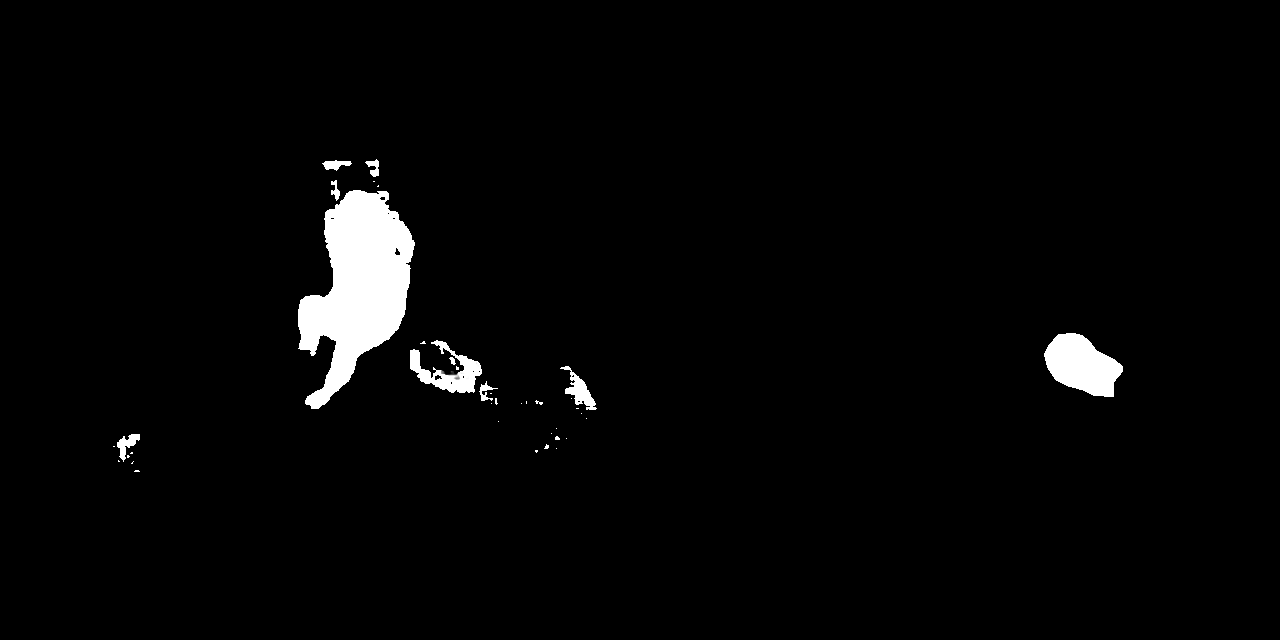

In [187]:
from random import randint
idx = randint(0,len(valid_curr_dataset)-1)
print(idx)

decoder_input, gt_masks, (input_size,original_size) = valid_curr_dataset[idx]
low_res_masks, iou_predictions = mask_decoder(**decoder_input)

upscaled_masks = predictor.model.postprocess_masks(low_res_masks, input_size, original_size).to(device)
binary_masks = normalize(threshold(upscaled_masks + 0.1, 0.0, 0)).to(device)[0,:,:,:]

# gt_binary_mask = torch.from_numpy(det_mask.astype(np.float32)).to(device)
# gt_binary_mask = get_gt_mask(gt_mask,gt_masks,binary_mask)
gt_binary_mask, binary_mask,*_ = get_max_iou_masks(gt_masks,binary_masks)

binary_mask = binary_masks[torch.argmax(iou_predictions).item()]

# binary_mask = binary_masks[0]
from PIL import Image
import numpy as np

from persam.persam_f import calculate_iou_loss, calculate_dice_loss, calculate_sigmoid_focal_loss

with torch.no_grad():
    flat_binary_mask = binary_mask.view(1,-1)
    flat_gt_binary_mask = gt_binary_mask.view(1,-1)

    focal_loss = calculate_sigmoid_focal_loss(flat_binary_mask, flat_gt_binary_mask,should_sigmoid=False)
    dice_loss = calculate_dice_loss(flat_binary_mask, flat_gt_binary_mask, should_sigmoid=False)
    iou_loss = calculate_iou_loss(flat_binary_mask, flat_gt_binary_mask, should_sigmoid=False)
    loss = focal_loss + dice_loss
    print(f"Loss: {loss:.4f}, Focal Loss: {focal_loss:.4f}, Dice Loss: {dice_loss:.4f}, IoU Loss: {iou_loss:.4f}")

def mask_to_img(mask):
    return Image.fromarray(mask.cpu().detach().numpy().astype(float) * 255).convert('RGB')

def clip_together_imgs(img1,img2):
    return Image.fromarray(np.hstack((img1,img2))).convert('RGB')

clip_together_imgs(mask_to_img(binary_mask),mask_to_img(gt_binary_mask))


In [110]:
from segment_anything import SamAutomaticMaskGenerator
from segment_anything import automatic_mask_generator
from persam.load import load_predictor
import cv2

model = load_predictor("vit_h").model.cuda()
# model.mask_decoder = mask_decoder

img = cv2.imread("demo-img.png")#list(climbing_dataset.images.values())[0]
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# raise NotImplementedError("TODO: fix this")

mask_generator = SamAutomaticMaskGenerator(model,stability_score_thresh=0.1)
print(f"Model threshold: {model.mask_threshold}, offset: {mask_generator.stability_score_offset}")

sam_result = mask_generator.generate(img)
raw_masks = automatic_mask_generator.latest_masks

if len(sam_result) == 0:
    print("No detections found")
    raise NotImplementedError("TODO: fix this")
detections = sv.Detections.from_sam(sam_result=sam_result)

annotator = sv.MaskAnnotator()
# paste each image into the new image
# detections = pred_dataset.annotations[img_name]
tmp_img = annotator.annotate(scene=img,detections=detections)
tmp_img = Image.fromarray(tmp_img)

tmp_img

Model threshold: 0.0, offset: 1.0
masks torch.bool
Mask threshold: 0.0, offset: 1.0, max: True
Intersections: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0', dtype=torch.int32)
Masks: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')
Unions: tensor([409600, 40

NotImplementedError: TODO: fix this

torch.Size([192, 640, 640]) torch.bool


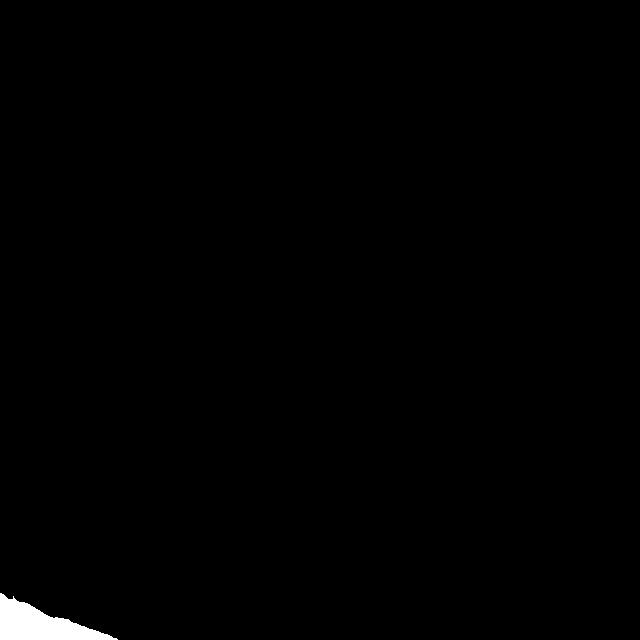

In [ ]:
from PIL import Image
import numpy as np
print(raw_masks.shape,raw_masks.dtype)
Image.fromarray(raw_masks[0].detach().cpu().numpy().astype(np.uint8) * 255)

In [ ]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "weights/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

In [ ]:
from fine_tune.samed import LoRA_Mask_Decoder

lora_mask_decoder = LoRA_Mask_Decoder(sam.mask_decoder,r=5)

lora_mask_decoder.load_lora_parameters("lora.pt")
mask_decoder = lora_mask_decoder.mask_decoder.cuda()

In [ ]:
import cv2
img = cv2.imread("demo-img.png")#list(climbing_dataset.images.values())[0]
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

masks = mask_generator.generate(img)

masks

[]

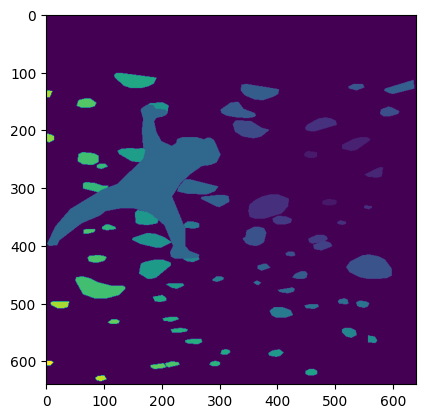

In [ ]:
from supervision.dataset.utils import approximate_mask_with_polygons

from random import choice
rand_img_name = choice(list(climbing_dataset.images.keys()))

rand_img_dets = climbing_dataset.annotations[rand_img_name]

biggest_mask = rand_img_dets.mask[rand_img_dets.area.argmax()]

from supervision.dataset.utils import approximate_mask_with_polygons
def dets_to_polygonss(dets):
    polygons = []
    for _,det_mask,*_ in dets:
        polygons.append(approximate_mask_with_polygons(det_mask))
    return polygons

def get_distances(point, polygonss):
    distances = np.zeros(len(polygonss), dtype=np.float32)
    for i,polygons in enumerate(polygonss):
        distances[i] = min([-cv2.pointPolygonTest(polygon, point, True) for polygon in polygons])
    
    distances = np.maximum(distances, 0)
    return distances

def show_closest_distances(point, dets):
    # get the distance of each det
    polygonss = dets_to_polygonss(dets)
    distances = get_distances(point, polygonss)

    # render the masks with their respective distances

    empty_map = np.zeros_like(dets.mask[0], dtype=np.float32)

    for i,(_,det_mask,*_) in enumerate(dets):
        empty_map[det_mask] = distances[i]

    return empty_map

polygons = approximate_mask_with_polygons(biggest_mask)

# make a signed distance map

empty_map = np.zeros(biggest_mask.shape, dtype=np.float32)

for i in range(biggest_mask.shape[0]):
    for j in range(biggest_mask.shape[1]):
        redPoint = (j,i)
        closestDist = cv2.pointPolygonTest(polygons[0], redPoint, True)

        empty_map[i, j] = -closestDist

empty_map = np.maximum(empty_map, 0)

from matplotlib import pyplot as plt

# plt.imshow(empty_map)

rand_point = (choice(range(biggest_mask.shape[0])), choice(range(biggest_mask.shape[1])))

plt.imshow(show_closest_distances(rand_point, rand_img_dets))